In [3]:
COMPARISONS = ['Lesion_Double_deep_tMPPCA_5D', 'Lesion_double_Ynet', 'Lesion_double_Ynet_fT', 'Lesion_Double_GT']

#COMPARISONS = ['Tumor_1_tMPPCA_5D', 'Tumor_1_deep_tMPPCA_5D','Tumor_1_Part_1_deep_tMPPCA_5D_Ynet', 'Tumor_1_noisy']

#COMPARISONS = ['Tumor_2_tMPPCA_5D', 'Tumor_2_deep_tMPPCA_5D','Tumor_2_noisy']

#COMPARISONS = ['P08_noisy', 'P08_deep_tMPPCA_5D', 'P08_tMPPCA_5D'] 

quality_clip = False # show voxels that meet LC Model quality criteria
outlier_clip = False
clip_pct = 2.0 # entfernt oberste 2% der fehlerpixl um außreißer zu vermeiden

z= 12 #9

# Available methods:
# - P08_noDenoising
# - P08_LR8
# - P08_unet_JInvariant
# - P08_zfT

# - P08_simulated_GT   -- that is ground truth
# - P08_simulated_noisy
# - P08_simulated_LR8
# - P08_simulated_unet_JInvariant

# - Sim_GT_lesion
# - Sim_lesion_deep
# - Sim_lesion_LR8
# - Sim_lesion_noisy

# Note I fitted many more methods, the result of which are in my home directory: /ceph/mri.meduniwien.ac.at/departments/radiology/mrsbrain/home/hfischer

## Fit Rate Laktat

In [4]:
# --- Fit-Rate (CRLB) Utilities ----------------------------------------------# --- Fit-Rate (CRLB) Utilities ----------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt

def _suffix(quality_clip: bool, outlier_clip: bool) -> str:
    return "OutlierClip" if outlier_clip else ("QualityClip" if quality_clip else "Orig")

def load_sd_map(
    metabolite: str,
    method: str,
    *,
    data_dir: str = "MetabMaps",
    quality_clip: bool = False,
    outlier_clip: bool = False,
) -> np.ndarray:
    """
    Lädt LCModel-SD/CRLB-Map (X,Y,Z,T) für ein Metabolit/Methodenpaar.
    Erwartet Dateien: MetabMaps/<method>/{metabolite}_sd_{method}_{Suffix}.npy
    """
    suffix = _suffix(quality_clip, outlier_clip)
    f_sd = os.path.join(data_dir, method, f"{metabolite}_sd_{method}_{suffix}.npy")
    if not os.path.isfile(f_sd):
        raise FileNotFoundError(f"SD fehlt: {f_sd}")
    sd = np.load(f_sd)
    if sd.ndim != 4:
        raise ValueError(f"Unerwartete SD-Shape {sd.shape}, erwartet (X,Y,Z,T).")
    return sd

def load_brain_mask(
    subject: str,
    *,
    tissue_dir: str = "../datasets",
) -> np.ndarray:
    """
    Lädt Hirnmaske (X,Y,Z). Erwartet: <tissue_dir>/<subject>/mask.npy
    Achtung: gleiche Achsentausch-Logik wie in deinem Code.
    """
    mask_path = os.path.join(tissue_dir, subject, "mask.npy")
    if not os.path.isfile(mask_path):
        raise FileNotFoundError(f"Maske fehlt: {mask_path}")
    brain_mask = np.swapaxes(np.load(mask_path), 0, -1) > 0
    return brain_mask

def fit_rate_from_sd(
    sd_4d: np.ndarray,
    brain_mask: np.ndarray,
    *,
    crlb_thresh: float = 20.0,
) -> np.ndarray:
    """
    Berechnet Fit-Rate (%) pro Zeitpunkt aus SD/CRLB (in %).
    Kriterium: SD <= crlb_thresh und finite Werte, nur innerhalb Hirnmaske.
    Return: (T,) in Prozent [0..100]
    """
    if sd_4d.shape[:3] != brain_mask.shape:
        raise ValueError(f"Masken-Shape {brain_mask.shape} passt nicht zu SD {sd_4d.shape[:3]}")
    X, Y, Z, T = sd_4d.shape
    mask = brain_mask & np.isfinite(sd_4d).all(axis=-1)  # nur Voxel, die über T finite sind
    # falls du pro Timepoint unterschiedliche Finite-Filter willst, kommentiere die Zeile oben aus
    rates = np.zeros(T, dtype=float)
    denom = mask.sum()
    if denom == 0:
        return np.full(T, np.nan)
    for t in range(T):
        sd_t = sd_4d[..., t]
        ok = (sd_t <= crlb_thresh) & np.isfinite(sd_t) & mask
        rates[t] = 100.0 * ok.sum() / denom
    return rates

def fit_rate_for_methods(
    metabolite: str,
    methods: list[str],
    subject: str,
    *,
    data_dir: str = "MetabMaps",
    tissue_dir: str = "../datasets",
    quality_clip: bool = False,
    outlier_clip: bool = False,
    crlb_thresh: float = 20.0,
) -> dict[str, np.ndarray]:
    """
    Lädt SD-Maps für mehrere Methoden und gibt Fit-Rate-Zeitreihen als Dict zurück.
    """
    brain_mask = load_brain_mask(subject, tissue_dir=tissue_dir)
    out = {}
    for m in methods:
        sd = load_sd_map(metabolite, m, data_dir=data_dir, quality_clip=quality_clip, outlier_clip=outlier_clip)
        out[m] = fit_rate_from_sd(sd, brain_mask, crlb_thresh=crlb_thresh)
    return out

def plot_fit_rate_bars(
    fit_rates: dict[str, np.ndarray],
    *,
    order: list[str] | None = None,
    title: str = "Fit-Rate (CRLB threshold)",
    crlb_thresh: float = 20.0,
    savepath: str | None = None,
    ymax: float | None = None,   # <--- NEU: y-Achsen-Maximum
):
    """
    Gruppierte Balken pro Zeitpunkt (Repetition) für mehrere Methoden.
    Optionales ymax-Argument zur Begrenzung der y-Achse.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    methods = order if order is not None else list(fit_rates.keys())

    # gleiche Anzahl Zeitpunkte prüfen
    Tset = {v.shape[0] for v in fit_rates.values()}
    if len(Tset) != 1:
        raise ValueError(f"Unterschiedliche Anzahl an Zeitpunkten: {Tset}")
    T = next(iter(Tset))

    xs = np.arange(1, T + 1)
    w = 0.8 / max(1, len(methods))
    plt.figure(figsize=(max(6, 1.2 * T), 4.2))

    for i, m in enumerate(methods):
        plt.bar(xs + (i - (len(methods) - 1) / 2) * w, fit_rates[m], width=w, label=m)

    plt.xticks(xs)
    plt.ylim(0, ymax if ymax is not None else 100)  # <--- hier ymax genutzt
    plt.xlabel("Repetition")
    plt.ylabel(f"Fit-Rate Lac (% voxels with CRLB ≤ {crlb_thresh:.0f}%)")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)
    plt.legend(frameon=False, ncol=len(methods))
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

def plot_fit_rate_two_panels(rates_lac, rates_glx, methods, *, minutes_per_rep=5, ymax=100, title="Fit-Rate (CRLB ≤ 30%)"):
    import numpy as np, matplotlib.pyplot as plt
    T = next(iter(rates_lac.values())).shape[0]
    tmin = np.arange(0, minutes_per_rep*T, minutes_per_rep)
    colors = ["#999999", "#6baed6", "#2171b5"]  # None, tMPPCA, This Work

    fig, axes = plt.subplots(1, 2, figsize=(9,3.6), sharey=True)
    for ax, rates, label in [(axes[0], rates_lac, "Lactate"), (axes[1], rates_glx, "Glx")]:
        for c, m in zip(colors, methods):
            ax.plot(tmin, rates[m], marker="o", lw=1.5, color=c, label=m if label=="Lactate" else None)
        ax.set_title(label)
        ax.set_xlabel("Time since start [min]")
        ax.grid(True, alpha=0.25)
        ax.set_ylim(0, ymax)
        ax.set_xticks(tmin)
    axes[0].set_ylabel("Fit rate [% voxels]")
    axes[0].legend(frameon=False, loc="upper left")
    fig.suptitle(title, y=1.04, fontsize=11)
    plt.tight_layout()
    plt.show()

def plot_fit_rate_two_metabolites_scatter(
    metabolites: list[str],
    fit_rate_dicts: list[dict[str, np.ndarray]],
    methods: list[str],
    *,
    labels: list[str] | None = None,
    minutes_per_rep: float = 5.0,
    crlb_thresh: float = 30.0,
    ymax: float = 100.0,
    title: str = "Fit-Rate (CRLB ≤ 30%)",
    savepath: str | None = None,
):
    """
    Zwei Panels (z.B. Lactate & Glx) als Scatter ohne Linien.
    Punkte pro Methode leicht seitlich versetzt.
    Speichert als PDF und positioniert den Titel direkt über der Figure.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    assert len(metabolites) == len(fit_rate_dicts) == 2, "Erwarte genau zwei Metabolite."
    if labels is None:
        labels = methods
    assert len(labels) == len(methods), "labels und methods müssen gleich lang sein."

    T = next(iter(fit_rate_dicts[0].values())).shape[0]
    time_min = np.arange(minutes_per_rep, minutes_per_rep * (T + 1), minutes_per_rep)

    colors  = ["#999999", "#6baed6", "#2171b5"]      # noisy / tMPPCA / this work
    markers = ["o", "s", "^"]
    offsets = np.linspace(-0.25, 0.25, num=len(methods)) * minutes_per_rep  # seitlicher Versatz

    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    for ax, metabolite, rates in zip(axes, metabolites, fit_rate_dicts):
        for (color, marker, method, dx, lab) in zip(colors, markers, methods, offsets, labels):
            y = rates[method]
            ax.scatter(
                time_min, y,
                s=44, marker=marker, edgecolors="none", #facecolors=color,
                label=lab if metabolite == metabolites[0] else None
            )
        ax.set_title(metabolite, fontsize=12)
        ax.set_xlabel("Time after ²H-glucose intake [min]", fontsize=11)
        ax.grid(True, axis="both", alpha=0.2, linewidth=0.6)
        ax.set_ylim(0, ymax)
        ax.set_yticks(np.arange(0, ymax+1, 20))
        ax.set_xticks(time_min)
        ax.tick_params(labelsize=10)
        #ax.axhline(0, color="0.0", linewidth=0.6)  # Baseline bei 0 %

    axes[0].set_ylabel(f"Voxels with CRLB ≤ {crlb_thresh:.0f}% [%]", fontsize=11)
    axes[0].legend(frameon=False, loc="upper left", fontsize=9)

    # ---- Titel wirklich nah an die Figure setzen ----
    plt.subplots_adjust(top=0.83)  # reduziert oberen Rand (Standard ~0.9)
    fig.text(0.5, 0.88, title, ha='center', va='bottom', fontsize=13, weight='bold')

    # ---- Layout & Speichern ----
    plt.tight_layout(rect=[0, 0, 1, 0.86])

    if savepath:
        if not savepath.lower().endswith(".pdf"):
            savepath = savepath + ".pdf"
        plt.savefig(savepath, dpi=300, bbox_inches="tight", transparent=True)
        print(f"💾 Gespeichert als: {savepath}")

    plt.show()

💾 Gespeichert als: fitrate_Lac_Glx_scatter.pdf


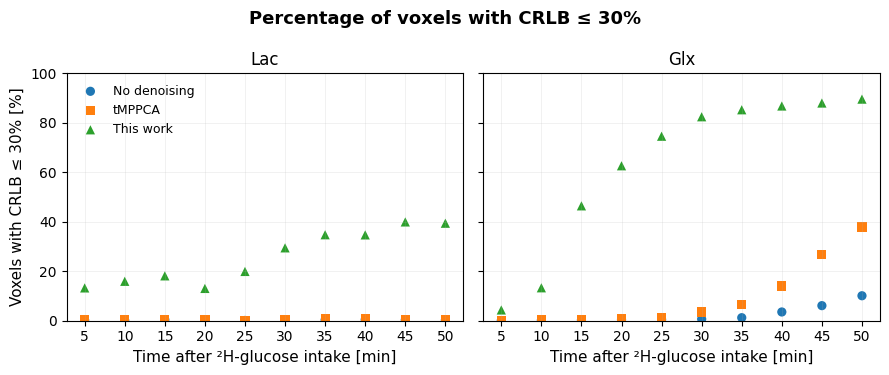

In [5]:
# --- Beispielaufruf ---
metabolites = ["Lac", "Glx"]

methods = ['Tumor_1_noisy', 'Tumor_1_tMPPCA_5D', 'Tumor_1_deep_tMPPCA_5D']
labels  = ['No denoising', 'tMPPCA', 'This work']

crlb_thresh = 30

subject = "Tumor_1"

rates_lac = fit_rate_for_methods(
    "Lac", methods, subject,
    data_dir="MetabMaps", tissue_dir="../datasets",
    crlb_thresh=crlb_thresh
)

rates_glx = fit_rate_for_methods(
    "Glx", methods, subject,
    data_dir="MetabMaps", tissue_dir="../datasets",
    crlb_thresh=crlb_thresh
)

plot_fit_rate_two_metabolites_scatter(
    metabolites=["Lac", "Glx"],
    fit_rate_dicts=[rates_lac, rates_glx],
    methods=methods,
    labels=labels,                # <--- deine niceren Legenden-Texte
    minutes_per_rep=5.0,
    crlb_thresh=crlb_thresh,
    ymax=100,
    title="Percentage of voxels with CRLB ≤ 30%",
    savepath="fitrate_Lac_Glx_scatter",
)

In [6]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

FONTSIZE = 16

def load_example_spectrum(
    base_dir: str,
    rep: int,
    xyz: tuple[int, int, int],
    filename: str = "SpecMap_LCMInput.nii.gz",
) -> np.ndarray:
    """Lädt 1D-Spektrum aus NIfTI (4D: X,Y,Z,S)."""
    spec_path = os.path.join(base_dir, "maps", str(rep), "SpecMap", filename)
    if not os.path.isfile(spec_path):
        raise FileNotFoundError(f"Spektrum nicht gefunden: {spec_path}")
    img = nib.load(spec_path)
    data = img.get_fdata()
    if data.ndim != 4:
        raise ValueError(f"Erwarte 4D (X,Y,Z,S), gefunden: {data.shape}")
    x, y, z = xyz
    return np.asarray(data[x, y, z, :], dtype=np.float64).ravel()


def plot_fit_rate_two_panels_with_spectra(
    rates_lac: dict[str, np.ndarray],
    rates_glx: dict[str, np.ndarray],
    methods: list[str],
    *,
    legend_labels: list[str] | None = None,
    minutes_per_rep: int = 5,
    ymax: float = 100,
    title: str = "Fit-Rate (CRLB ≤ 30%) and Example Spectra",
    base_dir_root: str,
    spec_rep: int,
    spec_xyz: tuple[int, int, int],
    spec_label: str | None = None,
    spec_ppm: np.ndarray | None = None,
    peak_labels: dict[str, float] | None = None,
):
    """Plots Fit-Rates (Lac/Glx, Scatter) + Beispiel-Spektren aller Methoden mit Peak-Beschriftungen."""
    T = next(iter(rates_lac.values())).shape[0]
    tmin = np.arange(minutes_per_rep, minutes_per_rep * (T+1), minutes_per_rep)

    if legend_labels is None:
        legend_labels = methods
    assert len(legend_labels) == len(methods), "legend_labels muss gleiche Länge wie methods haben"

    n_methods = len(methods)
    cmap = plt.cm.get_cmap("tab10", n_methods)
    colors = [cmap(i) for i in range(n_methods)]
    markers = ["o", "s", "^", "D", "v", "P", "X"]

    # --- Figure ---
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.8), sharey=False)
    fig.patch.set_facecolor("black")
    for ax in axes:
        ax.set_facecolor("black")

    ax_lac, ax_glx, ax_spec = axes

    # --- (1) Lactate (Scatter) ---
    for i, (c, m, label) in enumerate(zip(colors, methods, legend_labels)):
        mk = markers[i % len(markers)]
        ax_lac.scatter(tmin, rates_lac[m], s=36, marker=mk, color=c, label=label)
    ax_lac.set_title("Lac", fontsize=16, color="white")
    ax_lac.set_xlabel("Time since start [min]", fontsize=FONTSIZE, color="white")
    ax_lac.set_ylabel("Fit rate [% voxels]", fontsize=FONTSIZE, color="white")
    ax_lac.grid(True, alpha=0.25)
    ax_lac.set_ylim(0, ymax)
    ax_lac.tick_params(colors="white", labelsize=15)
    ax_lac.legend(frameon=False, loc="upper left", fontsize=FONTSIZE, labelcolor="white")
    for spine in ax_lac.spines.values():
        spine.set_visible(False)

    # --- (2) Glx (Scatter) ---
    for i, (c, m) in enumerate(zip(colors, methods)):
        mk = markers[i % len(markers)]
        ax_glx.scatter(tmin, rates_glx[m], s=36, marker=mk, color=c)
    ax_glx.set_title("Glx", fontsize=16, color="white")
    ax_glx.set_xlabel("Time since start [min]", fontsize=FONTSIZE, color="white")
    ax_glx.grid(True, alpha=0.25)
    ax_glx.set_ylim(0, ymax)
    ax_glx.tick_params(colors="white", labelsize=15)
    for spine in ax_glx.spines.values():
        spine.set_visible(False)

    # --- (3) Spektren (Linien) ---
    specs = []
    for c, m in zip(colors, methods):
        base_dir = os.path.join(base_dir_root, m)
        spec = load_example_spectrum(base_dir, spec_rep, spec_xyz)
        specs.append(spec / np.nanmax(np.abs(spec)))
        x_axis = spec_ppm if spec_ppm is not None else np.arange(spec.size)
        ax_spec.plot(x_axis, specs[-1], lw=1.4, color=c)
    ax_spec.set_title(spec_label or f"Spectrum @ (x,y,z)={spec_xyz}, Rep. {spec_rep}",
                      fontsize=16, color="white")
    ax_spec.set_xlabel("ppm" if spec_ppm is not None else "points",
                       fontsize=FONTSIZE, color="white")
    ax_spec.set_yticks([])
    ax_spec.set_ylabel("")
    ax_spec.grid(False)
    ax_spec.tick_params(colors="white", labelsize=16)
    # Keine Legende rechts
    for spine in ax_spec.spines.values():
        spine.set_visible(False)

    # ppm-Achse invertieren (8 → 1 ppm)
    if spec_ppm is not None:
        ax_spec.invert_xaxis()

    # --- Peak-Labels über Peaks der letzten Methode ---
    if peak_labels is not None and spec_ppm is not None:
        last_spec = specs[-1]
        ppm_axis = spec_ppm
        for name, ppm_pos in peak_labels.items():
            idx = np.argmin(np.abs(ppm_axis - ppm_pos))
            y_val = last_spec[idx]
            ax_spec.text(
                ppm_axis[idx], y_val + 0.12, name,
                color="white", ha="center", va="bottom", fontsize=FONTSIZE,
                bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.2")
            )

    fig.suptitle(title, y=1.02, fontsize=20, color="white")
    plt.tight_layout()
    plt.show()
    fig.savefig("TumorMetrics.pdf", bbox_inches='tight', facecolor=fig.get_facecolor())


/tmp/ipykernel_2096892/232738039.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", n_methods)


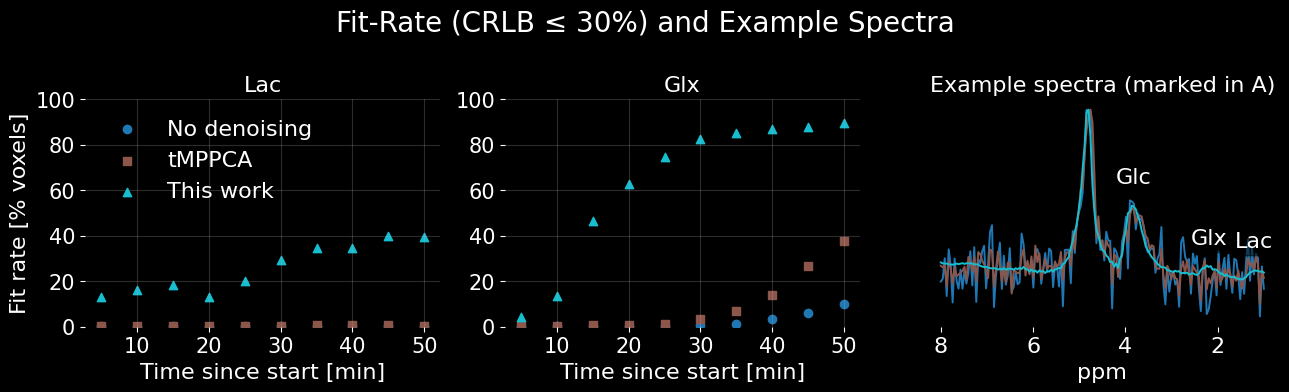

In [15]:
# --- Beispielaufruf ---
metabolites = ["Lac", "Glx"]

methods = ['Tumor_1_noisy', 'Tumor_1_tMPPCA_5D', 'Tumor_1_deep_tMPPCA_5D']
labels  = ['No denoising', 'tMPPCA', 'This work']

crlb_thresh = 30

subject = "Tumor_1"

rates_lac = fit_rate_for_methods(
    "Lac", methods, subject,
    data_dir="MetabMaps", tissue_dir="../datasets",
    crlb_thresh=crlb_thresh
)

rates_glx = fit_rate_for_methods(
    "Glx", methods, subject,
    data_dir="MetabMaps", tissue_dir="../datasets",
    crlb_thresh=crlb_thresh
)

# Plot:
plot_fit_rate_two_panels_with_spectra(
    rates_lac, rates_glx, methods,
    minutes_per_rep=5,
    ymax=100,
    title="Fit-Rate (CRLB ≤ 30%) and Example Spectra",
    base_dir_root="MetabMaps",   # enthält Unterordner für jede Methode
    spec_rep=10,                 # z. B. 50 min
    spec_xyz=(12, 14, 11),
    legend_labels=["No denoising", "tMPPCA", "This work"],  # ← Neue Option
    spec_label="Example spectra (marked in A)",
    peak_labels={"Lac": 1.2, "Glx": 2.2, "Glc": 3.8},
    spec_ppm=np.linspace(8, 1, 165)  # optional
)

### SNR & Sample spektra

In [8]:
import numpy as np

def snr_stats_from_npy(snr_path: str, pool_over_time: bool = False):
    """
    Lädt ein SNR-Array (Shape: x,y,z,T) aus .npy und berechnet Median & IQR.
    Berücksichtigt nur Voxel mit SNR > 0 (und finite).
    
    Args:
        snr_path: Pfad zur .npy-Datei (z. B. 'MetabMaps/P08_tMPPCA_5D/SNR_P08_tMPPCA_5D.npy')
        pool_over_time: Wenn True, werden alle T zusammen ausgewertet (ein Gesamtwert).
                        Wenn False, wird pro Zeitpunkt T ein Triplet (median, q25, q75) geliefert.

    Returns:
        Wenn pool_over_time:
            dict(overall=(median, q25, q75), n=Anzahl_Voxel)
        Sonst:
            dict(per_time=[(median_t, q25_t, q75_t), ...], n_per_time=[n_t, ...])
    """
    snr = np.load(snr_path)
    if snr.ndim != 4:
        raise ValueError(f"Erwarte 4D SNR (x,y,z,T); bekommen: {snr.shape}")

    # Maske: nur finite und > 0 (0 = außerhalb Hirnmaske)
    valid = np.isfinite(snr) & (snr > 0)

    if pool_over_time:
        vals = snr[valid]
        if vals.size == 0:
            return dict(overall=(np.nan, np.nan, np.nan), n=0)
        med  = np.median(vals)
        q25  = np.percentile(vals, 25)
        q75  = np.percentile(vals, 75)
        return dict(overall=(med, q25, q75), n=vals.size)
    else:
        T = snr.shape[-1]
        stats = []
        counts = []
        for t in range(T):
            vmask = valid[..., t]
            vals  = snr[..., t][vmask]
            if vals.size == 0:
                stats.append((np.nan, np.nan, np.nan))
                counts.append(0)
            else:
                med = np.median(vals)
                q25 = np.percentile(vals, 25)
                q75 = np.percentile(vals, 75)
                stats.append((med, q25, q75))
                counts.append(vals.size)
        return dict(per_time=stats, n_per_time=counts)

# --- Beispielnutzung ---
# 1) Pro Zeitpunkt:
Method = 'Tumor_1_deep_tMPPCA_5D'  #Tumor_1_noisy Tumor_1_deep_tMPPCA_5D Tumor_1_tMPPCA_5D

# res = snr_stats_from_npy(f"MetabMaps/{Method}/SNR_{Method}.npy", pool_over_time=False)
# print("per_time (median, q25, q75):", res["per_time"])

# 2) Über alle Zeitpunkte gepoolt (eine Zahl für den Abstract):
res_all = snr_stats_from_npy(f"MetabMaps/{Method}/SNR_{Method}.npy", pool_over_time=True)
med, q25, q75 = res_all["overall"]
print(f"Median SNR = {med:.2f} (IQR {q25:.2f}–{q75:.2f}), N={res_all['n']}")


Median SNR = 23.00 (IQR 14.00–30.00), N=19447


# Simulation evaluations

### Glx, Lac RMSE as function of time

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def rrmse_vs_ref(
    metabolite: str,
    methods: List[str],
    *,
    z: int,
    data_dir: str = "MetabMaps",
    quality_clip: bool = False,
    outlier_clip: bool = False,
    return_mask_counts: bool = False,
) -> Dict[str, np.ndarray]:
    """
    rRMSE(t) pro Methode (gegen Referenz = methods[-1]) für AMP-Maps.
    Nur Pixel, bei denen die Referenz im Slice z ungleich 0 und finite ist.
    rRMSE = RMSE / (max(ref) - min(ref)) pro Zeitpunkt.
    
    Returns:
        dict: {method_name: rrmse_time[T]}  (Referenz wird NICHT enthalten)
              optional zusätzlich 'Nmask': np.ndarray[T]
    """
    suffix = "OutlierClip" if outlier_clip else ("QualityClip" if quality_clip else "Orig")
    amps = {}

    # Laden aller Methoden
    for m in methods:
        f = os.path.join(data_dir, m, f"{metabolite}_amp_{m}_{suffix}.npy")
        if not os.path.isfile(f):
            raise FileNotFoundError(f"AMP fehlt: {f}")
        a = np.load(f)     # erwartet (Z, H, W, T)
        if a.ndim != 4:
            raise ValueError(f"Unerwartete Shape in {f}: {a.shape}, erwarte (Z,H,W,T)")
        amps[m] = a[z, ...]   # -> (H, W, T)

    ref_key = methods[-1]
    ref = amps[ref_key]                 # (H, W, T)
    T = ref.shape[-1]

    results: Dict[str, np.ndarray] = {}
    Nmask = np.zeros(T, dtype=int)

    for t in range(T):
        ref_t = ref[..., t]
        # Maske aus der Referenz (finite & != 0)
        mask_t = np.isfinite(ref_t) & (ref_t != 0)
        Nmask[t] = int(mask_t.sum())

        # Span der Referenz im maskierten Bereich
        if Nmask[t] == 0:
            span_t = 0.0
        else:
            ref_vals = ref_t[mask_t]
            span_t = np.nanmax(ref_vals) - np.nanmin(ref_vals)

        for m in methods[:-1]:  # alle außer Referenz
            a_t = amps[m][..., t]
            vmask = mask_t & np.isfinite(a_t)
            if vmask.sum() == 0 or span_t <= 0:
                val = np.nan
            else:
                diff = (a_t[vmask] - ref_t[vmask])
                rmse = float(np.sqrt(np.mean(diff**2)))
                val = rmse / span_t
            results.setdefault(m, np.zeros(T, dtype=float))[t] = val

    if return_mask_counts:
        results["Nmask"] = Nmask
    return results


import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from typing import Dict, List, Tuple

import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def plot_rrmse_vs_ref(
    metabolites: List[str],
    methods: List[str],
    *,
    z: int,
    data_dir: str = "MetabMaps",
    quality_clip: bool = False,
    outlier_clip: bool = False,
    minutes_per_rep: float = 5.0,
    labels: List[str] | None = None,      # darf len(methods)-1 ODER len(methods) haben
    ymax: float | None = None,
    title: str = "rRMSE vs. reference (AMP)",
    savepath: str | None = None,
) -> Tuple[Dict[str, Dict[str, np.ndarray]], np.ndarray]:
    """
    rRMSE(t) gegen die Referenz (methods[-1]); Referenz wird nicht geplottet.
    - Scatter-only, konsistente Farben/Marker
    - labels: entweder für alle Methoden (inkl. Referenz) ODER nur für die geplotteten (ohne Referenz)
    """
    # Farben/Marker konsistent mit deinem anderen Plot
    colors  = ["#999999", "#6baed6", "#2171b5", "#fb9a99", "#33a02c"]
    markers = ["o", "s", "^", "D", "P"]

    ref_key = methods[-1]
    plot_methods = methods[:-1]  # nur Nicht-Referenz

    # ---- Labels auf die geplotteten Methoden mappen ----
    if labels is None:
        plot_labels = plot_methods[:]  # Default: Namen als Labels
    else:
        if len(labels) == len(methods):
            # filtere das Label der Referenz raus (gleicher Index wie ref)
            plot_labels = labels[:-1]
        elif len(labels) == len(methods) - 1:
            plot_labels = labels
        else:
            raise ValueError(
                f"labels muss Länge {len(methods)-1} (ohne Referenz) "
                f"oder {len(methods)} (inkl. Referenz) haben, ist aber {len(labels)}."
            )

    # ---- rRMSE berechnen ----
    all_rrmse: Dict[str, Dict[str, np.ndarray]] = {}
    for metab in metabolites:
        rrmse_dict = rrmse_vs_ref(
            metab, methods, z=z, data_dir=data_dir,
            quality_clip=quality_clip, outlier_clip=outlier_clip
        )
        all_rrmse[metab] = rrmse_dict  # keys = plot_methods (+ optional 'Nmask' falls gesetzt)

    # ---- Zeitachse ----
    any_metab  = metabolites[0]
    any_method = next(iter(all_rrmse[any_metab].keys()))
    T = all_rrmse[any_metab][any_method].shape[0]
    time_min = np.arange(1, T+1, dtype=float) * minutes_per_rep

    # ---- Figure ----
    nM = len(metabolites)
    fig, axes = plt.subplots(1, nM, figsize=(9, 4), sharey=True)
    if nM == 1:
        axes = [axes]

    for ax, metab in zip(axes, metabolites):
        rrmse_dict = all_rrmse[metab]

        for idx, (m, lab) in enumerate(zip(plot_methods, plot_labels)):
            c  = colors[idx % len(colors)]
            mk = markers[idx % len(markers)]
            y  = rrmse_dict[m]
            ax.scatter(time_min, y, s=44, marker=mk, edgecolors="none", label=lab)

        ax.set_title(metab, fontsize=12)
        ax.set_xlabel("Time after ²H-glucose intake [min]", fontsize=11)
        ax.grid(True, axis="both", alpha=0.2, linewidth=0.6)
        if ymax is not None:
            ax.set_ylim(0, ymax)
        ax.set_xticks(time_min)
        ax.tick_params(labelsize=10)
        #ax.axhline(0, color="0.0", linewidth=0.6)

    axes[0].set_ylabel("relative RMSE wrt. ground truth", fontsize=11)
    axes[0].legend(frameon=False, loc="upper left", fontsize=9)

    # Titel nah an die Figure
    plt.subplots_adjust(top=0.83)
    fig.text(0.5, 0.88, f"{title}", ha='center', va='bottom', fontsize=13, weight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.86])

    if savepath:
        if not savepath.lower().endswith(".pdf"):
            savepath += ".pdf"
        plt.savefig(savepath, dpi=300, bbox_inches="tight", transparent=True)
        print(f"💾 Gespeichert als: {savepath}")

    plt.show()
    return all_rrmse, time_min





💾 Gespeichert als: RRMS_vs_Ref.pdf


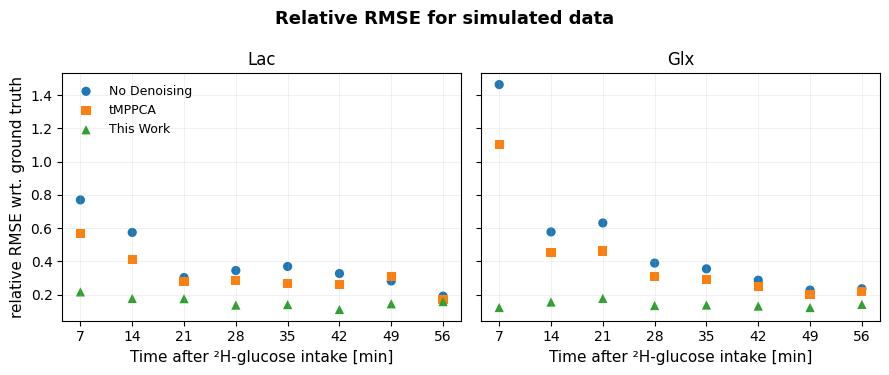

({'Lac': {'Lesion_Double_Noisy': array([0.76941487, 0.57390698, 0.30251656, 0.3446949 , 0.36912505,
          0.32670583, 0.2820462 , 0.19092558]),
   'Lesion_Double_tMPPCA_5D': array([0.56632838, 0.41279418, 0.27645349, 0.28244028, 0.26613882,
          0.2591355 , 0.30901643, 0.17246953]),
   'Lesion_Double_deep_tMPPCA_5D': array([0.21621039, 0.17678806, 0.17553303, 0.13670657, 0.13987047,
          0.11045987, 0.14461502, 0.15804049])},
  'Glx': {'Lesion_Double_Noisy': array([1.4631266 , 0.577011  , 0.63079946, 0.38941443, 0.35497427,
          0.28656024, 0.22692283, 0.23512149]),
   'Lesion_Double_tMPPCA_5D': array([1.1023718 , 0.45101783, 0.46253649, 0.31066647, 0.29009326,
          0.25032829, 0.19932161, 0.21742783]),
   'Lesion_Double_deep_tMPPCA_5D': array([0.12230678, 0.15517856, 0.17744194, 0.13419417, 0.13718978,
          0.13082757, 0.12206798, 0.14124148])}},
 array([ 7., 14., 21., 28., 35., 42., 49., 56.]))

In [10]:
# --- Setup ---
metabs = ["Lac", "Glx"]
methods     = ['Lesion_Double_deep_tMPPCA_5D', 'Lesion_Double_tMPPCA_5D', 'Lesion_Double_Noisy', 'Lesion_Double_GT'] # Referenz = letzter Eintrag

metabs = ["Lac", "Glx"]
methods = ['Lesion_Double_Noisy', 'Lesion_Double_tMPPCA_5D', 'Lesion_Double_deep_tMPPCA_5D', 'Lesion_Double_GT'] # Referenz = letzter Eintrag
labels = ["No Denoising", "tMPPCA", "This Work"]

plot_rrmse_vs_ref(
    metabolites=metabs,
    methods=methods,
    labels=labels,
    z=10,
    data_dir="MetabMaps",
    minutes_per_rep=7.0,
    title="Relative RMSE for simulated data",
    savepath="RRMS_vs_Ref"
)

# Tumor Graphik

/tmp/ipykernel_2096892/442791673.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_t1 = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
/tmp/ipykernel_2096892/442791673.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_ratio = mpl.cm.get_cmap("magma")


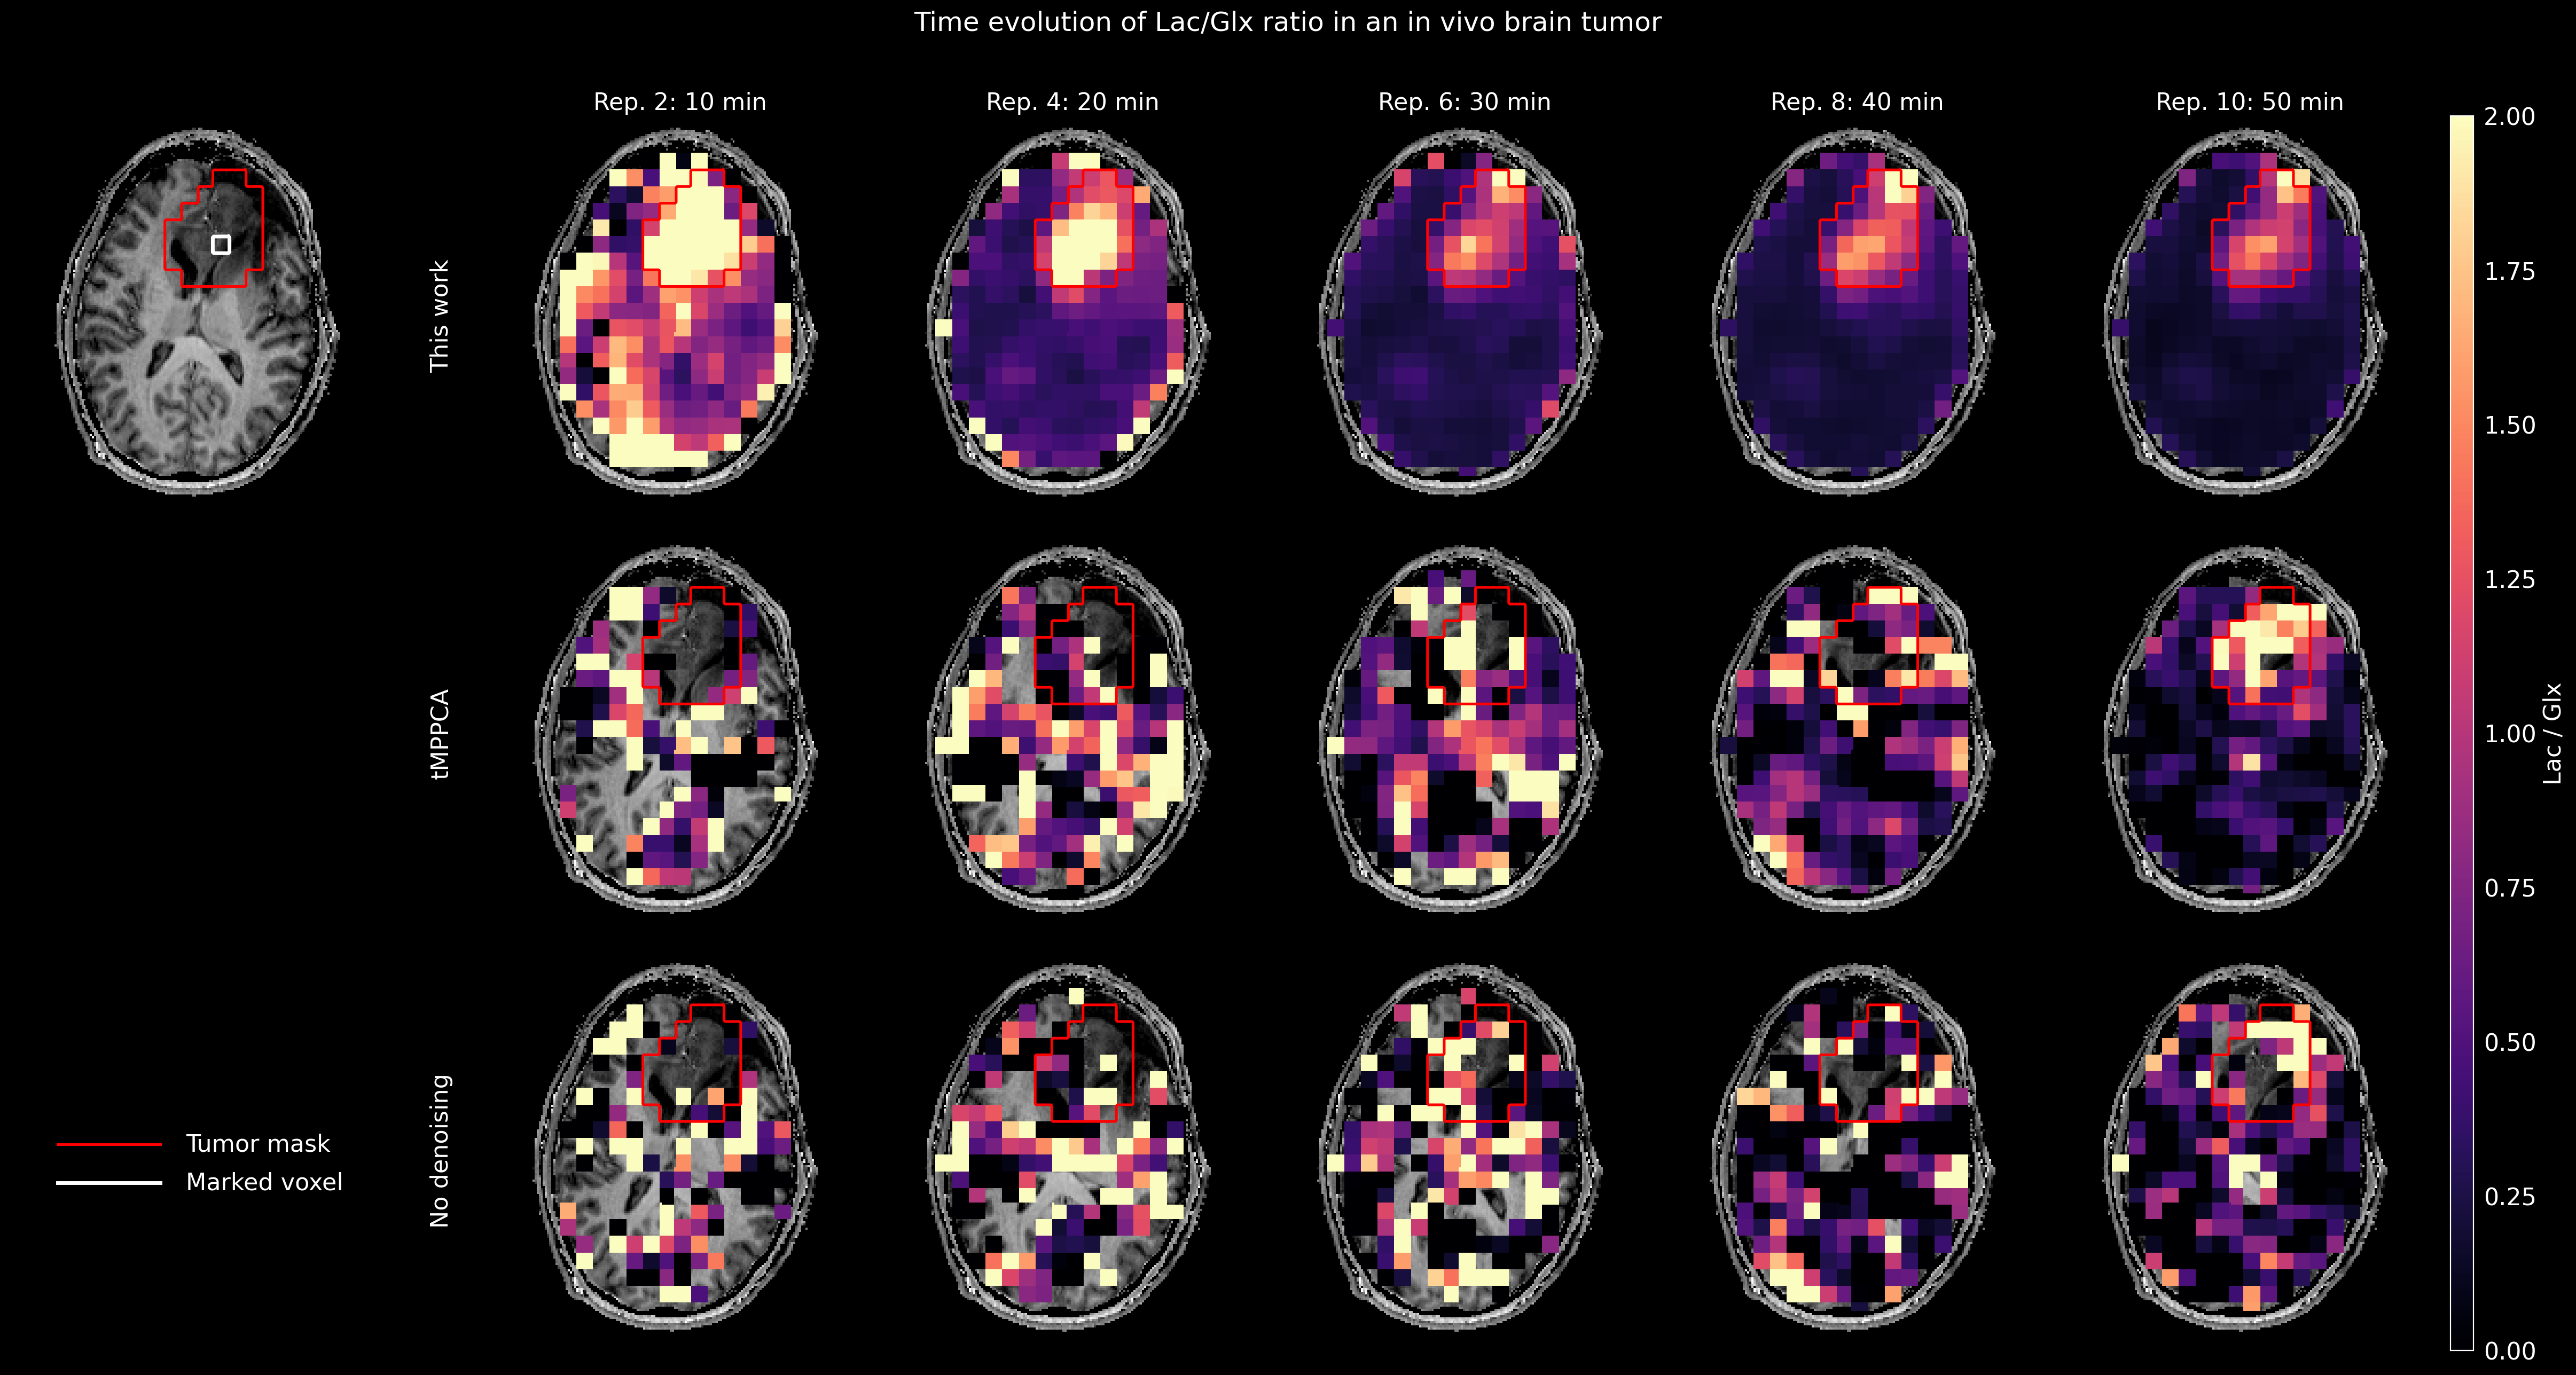

In [11]:
# pip install nibabel matplotlib numpy scikit-image
import os, numpy as np, nibabel as nib
from nibabel.processing import resample_from_to
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

def plot_dmi_timecourse_multi(
    BASE_LIST, T_INDEX_LIST,
    T1_Z=106, DMI_Z=11,
    T1_WINDOW=(1268, 3619), RATIO_RANGE=(0,2),
    LINEWIDTH=1.8, figsize_scale=1.0,
    method_labels=None, rep_labels=None,
    fontsize=16,
    # --- Neu ---
    DMI_BOX_I=None, DMI_BOX_J=None,
    box_linewidth=2.0, box_color='white',
    align_t1_to_dmi=True
):
    """
    - Einheitliche Schriftgröße (via `fontsize`)
    - Vertikale Methodenlabels links (eine Zelle pro Zeile)
    - Eine globale Colorbar
    - T1 nur in erster Zeile, T1 & Maske nur einmal aus erster Methode
    - Spaltentitel (Repetitionslabels) optional über `rep_labels` übergeben
    - NEU: Weißes Kästchen auf dem T1-Bild für einen DMI-Voxel via (DMI_BOX_I, DMI_BOX_J)
           Optional: `align_t1_to_dmi=True` zeigt die zur DMI-Slice passende T1-Slice.
    """

    assert len(BASE_LIST) >= 1, "BASE_LIST darf nicht leer sein."
    if method_labels is not None:
        assert len(method_labels) == len(BASE_LIST), "method_labels muss gleich lang wie BASE_LIST sein."
    if rep_labels is not None:
        assert len(rep_labels) == len(T_INDEX_LIST), "rep_labels muss gleich lang wie T_INDEX_LIST sein."

    # --- Gemeinsames T1 + Tumormaske nur aus der 1. Methode laden ---
    base0 = BASE_LIST[0]
    T1_PATH   = os.path.join(base0, "maps", "magnitude.nii")
    MASK_PATH = os.path.join(base0, "maps", "Tumor_1_mask.nii")

    t1_img   = nib.load(T1_PATH)
    mask_img = nib.load(MASK_PATH)
    t1 = t1_img.get_fdata()
    t1_aff, t1_shape = t1_img.affine, t1_img.shape
    mask_t1_nn = resample_from_to(mask_img, (t1_shape, t1_aff), order=0).get_fdata() > 0

    # --- Hilfsfunktion: DMI-Z -> T1-Z ---
    def dmi_z_to_t1_z(dmi_img, t1_affine, t1_shape, dmi_z):
        sx, sy, _ = dmi_img.shape
        ijk_dmi = np.array([sx/2.0, sy/2.0, dmi_z, 1.0])
        xyz = dmi_img.affine @ ijk_dmi
        ijk_t1 = np.linalg.inv(t1_affine) @ xyz
        return int(np.clip(np.rint(ijk_t1[2]), 0, t1_shape[2]-1))

    # --- NEU: Kästchen affine-sicher via Resampling ---
    def draw_dmi_voxel_box_via_resample(ax, dmi_img, i, j, dmi_z, t1_shape, t1_affine,
                                        t1_slice_index, edgecolor='white', lw=2.0):
        """
        Markiert den DMI-Voxel (i,j,dmi_z), indem eine 1-voxel-Binärmaske aus DMI-Raum
        nach T1-Raum resampled wird. Dann wird auf der gewünschten T1-Scheibe die Kontur gezeichnet.
        -> affine-sicher, unabhängig von Achsendrehungen/Flips.
        """
        if i is None or j is None:
            return
        dmi_data_shape = dmi_img.shape
        if not (0 <= i < dmi_data_shape[0] and 0 <= j < dmi_data_shape[1] and 0 <= dmi_z < dmi_data_shape[2]):
            return

        mask_dmi = np.zeros(dmi_data_shape, dtype=np.uint8)
        mask_dmi[i, j, dmi_z] = 1
        mask_dmi_img = nib.Nifti1Image(mask_dmi, dmi_img.affine)

        mask_t1 = resample_from_to(mask_dmi_img, (t1_shape, t1_affine), order=0).get_fdata() > 0
        slice_bin = mask_t1[..., t1_slice_index].T  # wegen imshow(... .T, origin='lower')
        contours = measure.find_contours(slice_bin.astype(float), 0.5)
        for c in contours:
            ax.plot(c[:,1], c[:,0], color=edgecolor, linewidth=lw)

    # --- Ratio-Loader ---
    def load_ratio_on_t1(BASE, T_index):
        lac_img = nib.load(os.path.join(BASE, "maps", f"{T_index}", "Orig", "Lac_amp_map.nii"))
        glx_img = nib.load(os.path.join(BASE, "maps", f"{T_index}", "Orig", "Glx_amp_map.nii"))
        lac_r = resample_from_to(lac_img, (t1_shape, t1_aff), order=0).get_fdata()
        glx_r = resample_from_to(glx_img, (t1_shape, t1_aff), order=0).get_fdata()
        eps = 1e-6
        ratio = np.full_like(lac_r, np.nan, dtype=np.float32)
        m = np.isfinite(lac_r) & np.isfinite(glx_r) & (glx_r > eps)
        ratio[m] = lac_r[m] / glx_r[m]
        return ratio

    # === Figure & GridSpec ===
    n_ratio = len(T_INDEX_LIST)
    nrows = len(BASE_LIST)
    ncols = 1 + 1 + n_ratio + 1  # [T1] | [LABELS] | [Ratios...] | [Cbar]

    fig_w = figsize_scale * (ncols * 3.0)
    fig_h = figsize_scale * (nrows * 4.0)

    fig = plt.figure(figsize=(fig_w, fig_h), dpi=200, constrained_layout=True)
    fig.patch.set_facecolor('black')
    gs = GridSpec(
        nrows, ncols, figure=fig,
        width_ratios=[1, 0.2] + [1]*n_ratio + [0.06],
        height_ratios=[1]*nrows
    )

    cmap_t1 = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
    cmap_ratio = mpl.cm.get_cmap("magma")
    norm_ratio = mpl.colors.Normalize(vmin=RATIO_RANGE[0], vmax=RATIO_RANGE[1], clip=True)
    t1_vmin, t1_vmax = T1_WINDOW

    last_im = None

    lac0_img_for_z = nib.load(os.path.join(BASE_LIST[0], "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
    T1_Z_MATCH_GLOBAL = dmi_z_to_t1_z(lac0_img_for_z, t1_aff, t1_shape, DMI_Z)

    for r, BASE in enumerate(BASE_LIST):
        lac0_img = nib.load(os.path.join(BASE, "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
        T1_Z_MATCH = dmi_z_to_t1_z(lac0_img, t1_aff, t1_shape, DMI_Z)

        # --- T1 (nur erste Zeile) ---
        if r == 0:
            ax_t1 = fig.add_subplot(gs[r, 0])
            ax_t1.axis('off')
            t1_z_to_show = T1_Z_MATCH_GLOBAL if align_t1_to_dmi else T1_Z
            ax_t1.imshow(t1[..., t1_z_to_show].T, cmap=cmap_t1,
                         vmin=t1_vmin, vmax=t1_vmax,
                         origin='lower', interpolation='nearest')
            for c in measure.find_contours(mask_t1_nn[..., t1_z_to_show].T.astype(float), 0.5):
                ax_t1.plot(c[:,1], c[:,0], color='red', linewidth=LINEWIDTH)

            # Kästchen über DMI-Voxel
            if DMI_BOX_I is not None and DMI_BOX_J is not None:
                draw_dmi_voxel_box_via_resample(
                    ax=ax_t1, dmi_img=lac0_img_for_z,
                    i=DMI_BOX_I, j=DMI_BOX_J, dmi_z=DMI_Z,
                    t1_shape=t1_shape, t1_affine=t1_aff,
                    t1_slice_index=t1_z_to_show,
                    edgecolor=box_color, lw=box_linewidth
                )
        else:
            ax_blank = fig.add_subplot(gs[r, 0])
            ax_blank.axis('off')
            ax_blank.set_facecolor('black')

        # --- Vertikale Label-Spalte ---
        ax_label = fig.add_subplot(gs[r, 1])
        ax_label.axis('off')
        ax_label.set_facecolor('black')
        label = method_labels[r] if method_labels is not None else os.path.basename(os.path.normpath(BASE))
        ax_label.text(0.5, 0.5, label, color='white', fontsize=fontsize,
                      rotation=90, ha='center', va='center', transform=ax_label.transAxes)

        # --- Ratio-Spalten ---
        for j, T_idx in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, 2 + j])
            ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1,
                      vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            ratio_j = load_ratio_on_t1(BASE, T_idx)
            last_im = ax.imshow(np.ma.masked_invalid(ratio_j[..., T1_Z_MATCH].T),
                                cmap=cmap_ratio, norm=norm_ratio,
                                origin='lower', interpolation='nearest')
            for c in measure.find_contours(mask_t1_nn[..., T1_Z_MATCH].T.astype(float), 0.5):
                ax.plot(c[:,1], c[:,0], color='red', linewidth=LINEWIDTH)
            if r == 0:
                title_txt = rep_labels[j] if rep_labels is not None else f"T={T_idx}"
                ax.set_title(title_txt, color='white', fontsize=fontsize, pad=4)

    # --- Eine gemeinsame Colorbar ---
    cax = fig.add_subplot(gs[:, ncols-1])
    if last_im is not None:
        cbar = fig.colorbar(last_im, cax=cax)
        cbar.ax.set_facecolor('black')
        cbar.outline.set_edgecolor('white')
        plt.setp(cbar.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar.set_label("Lac / Glx", color='white', fontsize=fontsize)

    fig.suptitle(
    "Time evolution of Lac/Glx ratio in an in vivo brain tumor",
    color='white', fontsize=fontsize + 2, y=1.06)
    
        # --- Legende unten links ---
    legend_x = 0.02   # horizontaler Abstand vom linken Rand
    legend_y = 0.175   # vertikaler Abstand vom unteren Rand
    legend_dx = 0.04  # Länge der Linien

    # Tumor mask (rot)
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                            [legend_y, legend_y],
                            color='red', linewidth=LINEWIDTH,
                            transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y, "Tumor mask",
            color='white', va='center', fontsize=fontsize, transform=fig.transFigure)

    # Marked voxel (weiß)
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                            [legend_y - 0.03, legend_y - 0.03],
                            color='white', linewidth=box_linewidth,
                            transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y - 0.03, "Marked voxel",
            color='white', va='center', fontsize=fontsize, transform=fig.transFigure)


    plt.show()
    fig.savefig("output.pdf", bbox_inches='tight', facecolor=fig.get_facecolor())


# Beispielaufruf:
plot_dmi_timecourse_multi(
    BASE_LIST=[
        "MetabMaps/Tumor_1_deep_tMPPCA_5D",
        "MetabMaps/Tumor_1_tMPPCA_5D",
        "MetabMaps/Tumor_1_noisy"
    ],
    T_INDEX_LIST=[2,4,6,8,10],
    method_labels=["This work", "tMPPCA", "No denoising"], 
    rep_labels=["Rep. 2: 10 min", "Rep. 4: 20 min", "Rep. 6: 30 min", "Rep. 8: 40 min", "Rep. 10: 50 min"],
    DMI_BOX_I=12, DMI_BOX_J=14, DMI_Z=11,
    align_t1_to_dmi=True,
    box_linewidth=2.5, box_color='white'
)


# Simulations Graphik

/tmp/ipykernel_2096892/1231432364.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_t1  = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
/tmp/ipykernel_2096892/1231432364.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lac = mpl.cm.get_cmap("magma")
/tmp/ipykernel_2096892/1231432364.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_glx = mpl.cm.get_cmap("magma")


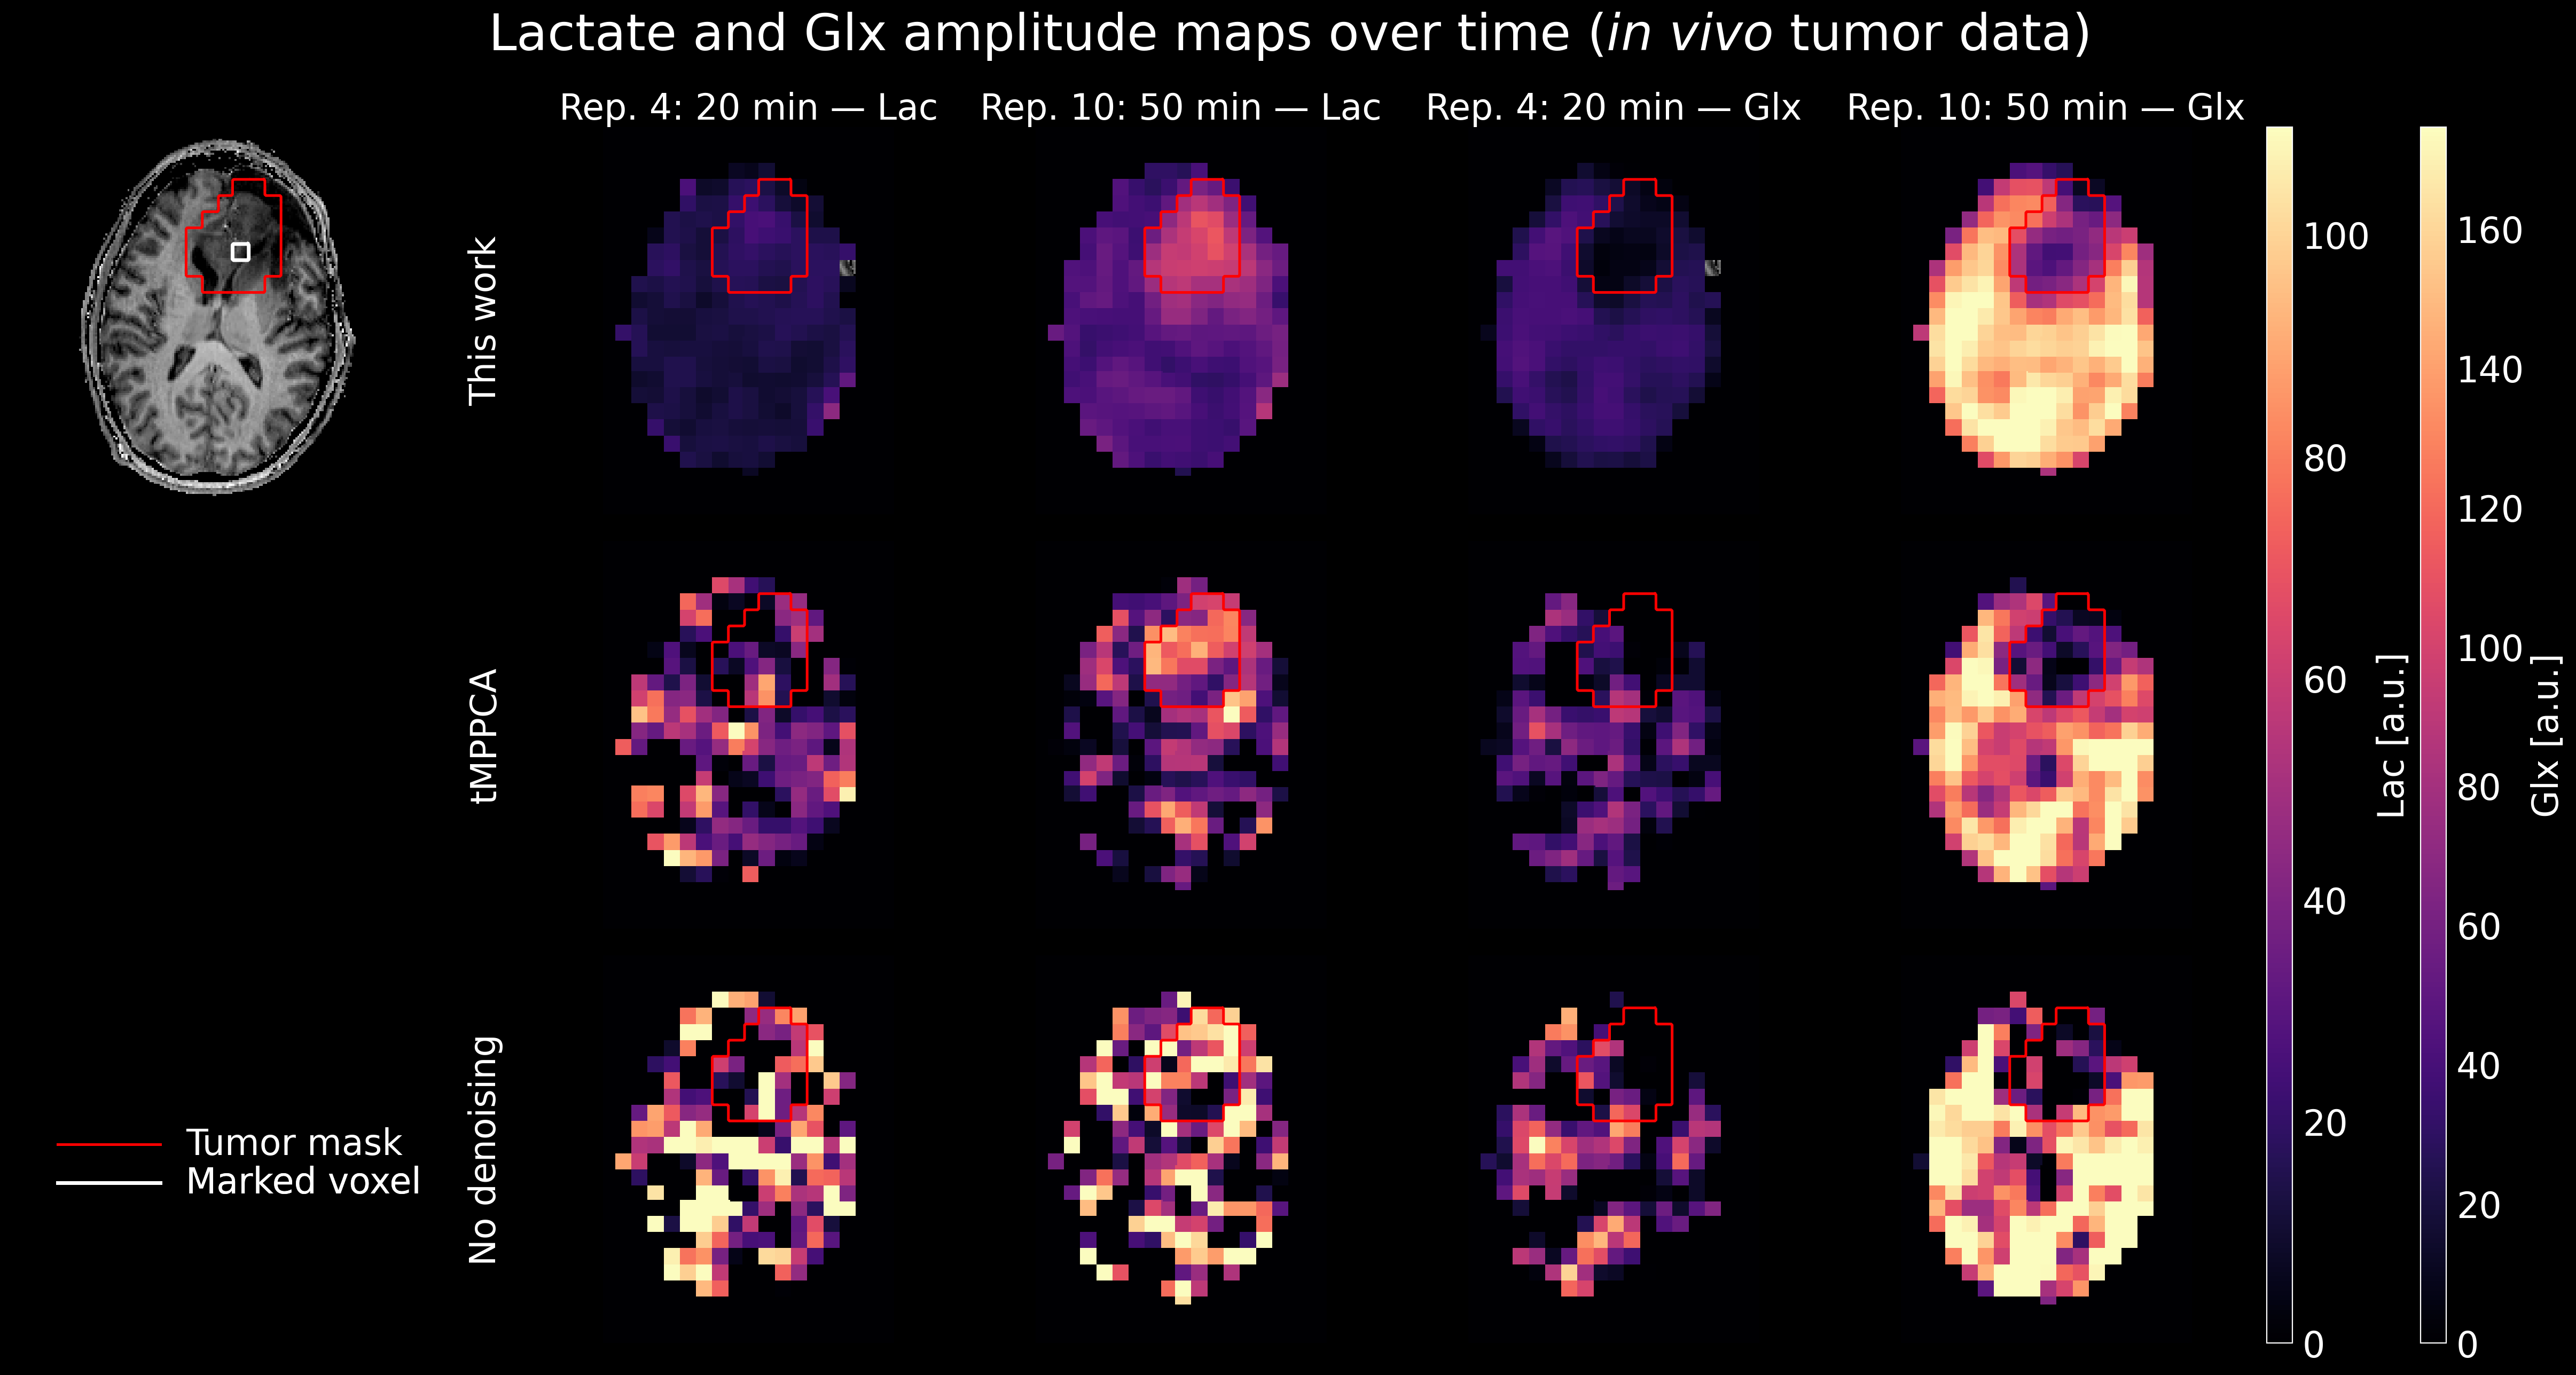

In [12]:
# pip install nibabel matplotlib numpy scikit-image
import os, numpy as np, nibabel as nib
from nibabel.processing import resample_from_to
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

def plot_dmi_timecourse_multi(
    BASE_LIST, T_INDEX_LIST,
    T1_Z=106, DMI_Z=11,
    T1_WINDOW=(1268, 3619),
    LINEWIDTH=1.8, figsize_scale=1.0,
    method_labels=None, rep_labels=None,
    fontsize=24,
    DMI_BOX_I=None, DMI_BOX_J=None, box_linewidth=2.0, box_color='white',
    align_t1_to_dmi=True,
    # feste Skalen optional; sonst Auto über alle Methoden/Zeitpunkte (Perzentile)
    LAC_CLIM=None, GLX_CLIM=None, clim_percentiles=(1, 99)
):
    assert len(BASE_LIST) >= 1
    if method_labels is not None: assert len(method_labels) == len(BASE_LIST)
    if rep_labels is not None:    assert len(rep_labels) == len(T_INDEX_LIST)

    # --- T1 (+ optionale Tumormaske) aus erster Methode ---
    base0 = BASE_LIST[0]
    T1_PATH   = os.path.join(base0, "maps", "magnitude.nii")
    MASK_PATH = os.path.join(base0, "maps", "Tumor_1_mask.nii")  # falls nicht vorhanden, wird ignoriert

    t1_img = nib.load(T1_PATH)
    t1 = t1_img.get_fdata()
    t1_aff, t1_shape = t1_img.affine, t1_img.shape

    mask_t1_nn = None
    if os.path.exists(MASK_PATH):
        mask_img = nib.load(MASK_PATH)
        mask_t1_nn = resample_from_to(mask_img, (t1_shape, t1_aff), order=0).get_fdata() > 0

    # --- DMI-Z -> T1-Z ---
    def dmi_z_to_t1_z(dmi_img, t1_affine, t1_shape, dmi_z):
        sx, sy, _ = dmi_img.shape
        ijk_dmi = np.array([sx/2.0, sy/2.0, dmi_z, 1.0])
        xyz = dmi_img.affine @ ijk_dmi
        ijk_t1 = np.linalg.inv(t1_affine) @ xyz
        return int(np.clip(np.rint(ijk_t1[2]), 0, t1_shape[2]-1))

    # --- Markierungsbox (affine-sicher) ---
    def draw_dmi_voxel_box_via_resample(ax, dmi_img, i, j, dmi_z, t1_shape, t1_affine,
                                        t1_slice_index, edgecolor='white', lw=2.0):
        if i is None or j is None: return
        shp = dmi_img.shape
        if not (0 <= i < shp[0] and 0 <= j < shp[1] and 0 <= dmi_z < shp[2]): return
        mask_dmi = np.zeros(shp, dtype=np.uint8); mask_dmi[i, j, dmi_z] = 1
        mask_t1 = resample_from_to(nib.Nifti1Image(mask_dmi, dmi_img.affine),
                                   (t1_shape, t1_aff), order=0).get_fdata() > 0
        for c in measure.find_contours(mask_t1[..., t1_slice_index].T.astype(float), 0.5):
            ax.plot(c[:,1], c[:,0], color=edgecolor, linewidth=lw)

    # --- Loader für Metabolit (auf T1-Raster) ---
    def load_metab_on_t1(BASE, T_index, metab):  # metab in {"Lac","Glx"}
        p = os.path.join(BASE, "maps", f"{T_index}", "Orig", f"{metab}_amp_map.nii")
        img = nib.load(p)
        return resample_from_to(img, (t1_shape, t1_aff), order=0).get_fdata()

    # globale DMI→T1-Slice
    lac0_img_for_z = nib.load(os.path.join(BASE_LIST[0], "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
    T1_Z_MATCH_GLOBAL = dmi_z_to_t1_z(lac0_img_for_z, t1_aff, t1_shape, DMI_Z)

    # --- Auto-CLIMs, falls nicht vorgegeben: über ALLE Methoden & Zeitpunkte ---
    def gather_vals(metab):
        vals = []
        for B in BASE_LIST:
            for T in T_INDEX_LIST:
                a = load_metab_on_t1(B, T, metab)
                vals.append(a[np.isfinite(a)])
        vals = np.concatenate(vals) if len(vals)>1 else vals[0]
        p1, p99 = np.percentile(vals, clim_percentiles)
        if p1 == p99: p99 = p1 + 1.0
        return (float(p1), float(p99))

    if LAC_CLIM is None: LAC_CLIM = gather_vals("Lac")
    if GLX_CLIM is None: GLX_CLIM = gather_vals("Glx")

    # === Layout: T1 | Label | (alle Lac) | (alle Glx) | Cbar Lac | Cbar Glx ===
    n_times = len(T_INDEX_LIST)
    nrows = len(BASE_LIST)
    ncols = 1 + 1 + n_times + n_times + 2

    fig_w = figsize_scale * (ncols * 3.0)
    fig_h = figsize_scale * (nrows * 4.0)
    fig = plt.figure(figsize=(fig_w, fig_h), dpi=200, constrained_layout=True)
    fig.patch.set_facecolor('black')

    width_ratios = [1, 0.2] + [1]*n_times + [1]*n_times + [0.06, 0.06]
    gs = GridSpec(nrows, ncols, figure=fig, width_ratios=width_ratios, height_ratios=[1]*nrows)

    cmap_t1  = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
    cmap_lac = mpl.cm.get_cmap("magma")
    cmap_glx = mpl.cm.get_cmap("magma")
    norm_lac = mpl.colors.Normalize(vmin=LAC_CLIM[0], vmax=LAC_CLIM[1], clip=True)
    norm_glx = mpl.colors.Normalize(vmin=GLX_CLIM[0], vmax=GLX_CLIM[1], clip=True)
    t1_vmin, t1_vmax = T1_WINDOW

    last_im_lac = None
    last_im_glx = None

    for r, BASE in enumerate(BASE_LIST):
        # Slice-Matching für diese Zeile
        lac0_img = nib.load(os.path.join(BASE, "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
        T1_Z_MATCH = dmi_z_to_t1_z(lac0_img, t1_aff, t1_shape, DMI_Z)

        # T1 (nur erste Zeile)
        if r == 0:
            ax_t1 = fig.add_subplot(gs[r, 0]); ax_t1.axis('off')
            zshow = T1_Z_MATCH_GLOBAL if align_t1_to_dmi else T1_Z
            ax_t1.imshow(t1[..., zshow].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                         origin='lower', interpolation='nearest')
            if mask_t1_nn is not None:
                for c in measure.find_contours(mask_t1_nn[..., zshow].T.astype(float), 0.5):
                    ax_t1.plot(c[:,1], c[:,0], color='red', linewidth=LINEWIDTH)
            if DMI_BOX_I is not None and DMI_BOX_J is not None:
                draw_dmi_voxel_box_via_resample(ax_t1, lac0_img_for_z, DMI_BOX_I, DMI_BOX_J, DMI_Z,
                                                t1_shape, t1_aff, zshow, edgecolor=box_color, lw=box_linewidth)
        else:
            ax_blank = fig.add_subplot(gs[r, 0]); ax_blank.axis('off'); ax_blank.set_facecolor('black')

        # vertikales Methodenlabel
        ax_label = fig.add_subplot(gs[r, 1]); ax_label.axis('off'); ax_label.set_facecolor('black')
        label = method_labels[r] if method_labels is not None else os.path.basename(os.path.normpath(BASE))
        ax_label.text(0.5, 0.5, label, color='white', fontsize=fontsize,
                      rotation=90, ha='center', va='center', transform=ax_label.transAxes)

        # --- LAC-Blöcke (alle Zeiten nebeneinander) ---
        for j, T in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, 2 + j]); ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            lac = load_metab_on_t1(BASE, T, "Lac")
            last_im_lac = ax.imshow(np.ma.masked_invalid(lac[..., T1_Z_MATCH].T),
                                    cmap=cmap_lac, norm=norm_lac, origin='lower', interpolation='nearest')
            if mask_t1_nn is not None:
                for c in measure.find_contours(mask_t1_nn[..., T1_Z_MATCH].T.astype(float), 0.5):
                    ax.plot(c[:,1], c[:,0], color='red', linewidth=LINEWIDTH)
            if r == 0:
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"{tlabel} — Lac", color='white', fontsize=fontsize, pad=4)

        # --- GLX-Blöcke (alle Zeiten nebeneinander) ---
        glx_offset = 2 + n_times  # Startspalte der Glx-Blöcke
        for j, T in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, glx_offset + j]); ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            glx = load_metab_on_t1(BASE, T, "Glx")
            last_im_glx = ax.imshow(np.ma.masked_invalid(glx[..., T1_Z_MATCH].T),
                                    cmap=cmap_glx, norm=norm_glx, origin='lower', interpolation='nearest')
            if mask_t1_nn is not None:
                for c in measure.find_contours(mask_t1_nn[..., T1_Z_MATCH].T.astype(float), 0.5):
                    ax.plot(c[:,1], c[:,0], color='red', linewidth=LINEWIDTH)
            if r == 0:
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"{tlabel} — Glx", color='white', fontsize=fontsize, pad=4)

    # --- zwei globale Colorbars ---
    cax_lac = fig.add_subplot(gs[:, ncols-2])
    if last_im_lac is not None:
        cbar_lac = fig.colorbar(last_im_lac, cax=cax_lac)
        cbar_lac.ax.set_facecolor('black'); cbar_lac.outline.set_edgecolor('white')
        plt.setp(cbar_lac.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar_lac.set_label("Lac [a.u.]", color='white', fontsize=fontsize)

    cax_glx = fig.add_subplot(gs[:, ncols-1])
    if last_im_glx is not None:
        cbar_glx = fig.colorbar(last_im_glx, cax=cax_glx)
        cbar_glx.ax.set_facecolor('black'); cbar_glx.outline.set_edgecolor('white')
        plt.setp(cbar_glx.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar_glx.set_label("Glx [a.u.]", color='white', fontsize=fontsize)

    fig.suptitle("Lactate and Glx amplitude maps over time ($\\it{in\\ vivo}$ tumor data)",
             color='white', fontsize=fontsize + 10, y=1.06)

    # Legende: Marked voxel
    legend_x, legend_y, legend_dx = 0.02, 0.175, 0.04
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                              [legend_y - 0.03, legend_y - 0.03],
                              color='white', linewidth=box_linewidth,
                              transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y - 0.03, "Marked voxel",
             color='white', va='center', fontsize=fontsize, transform=fig.transFigure)

    # --- Legende unten links ---
    legend_x = 0.02   # horizontaler Abstand vom linken Rand
    legend_y = 0.175  # vertikaler Abstand vom unteren Rand
    legend_dx = 0.04  # Länge der Linien

    # Tumor mask (rot)
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                              [legend_y, legend_y],
                              color='red', linewidth=LINEWIDTH,
                              transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y, "Tumor mask",
             color='white', va='center', fontsize=fontsize, transform=fig.transFigure)

    # Marked voxel (weiß)
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                              [legend_y - 0.03, legend_y - 0.03],
                              color='white', linewidth=box_linewidth,
                              transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y - 0.03, "Marked voxel",
             color='white', va='center', fontsize=fontsize, transform=fig.transFigure)


    plt.show()
    fig.savefig("output.pdf", bbox_inches='tight', facecolor=fig.get_facecolor())


# Beispielaufruf (unverändert):
plot_dmi_timecourse_multi(
    BASE_LIST=[
        "MetabMaps/Tumor_1_deep_tMPPCA_5D",
        "MetabMaps/Tumor_1_tMPPCA_5D",
        "MetabMaps/Tumor_1_noisy"
    ],
    T_INDEX_LIST=[4,10],
    method_labels=["This work", "tMPPCA", "No denoising"],
    rep_labels=["Rep. 4: 20 min", "Rep. 10: 50 min"],
    DMI_BOX_I=12, DMI_BOX_J=14, DMI_Z=11,
    align_t1_to_dmi=True,
    box_linewidth=2.5, box_color='white'
    # Optional feste Skalen:
    # LAC_CLIM=(0,2.0), GLX_CLIM=(0,2.0)
)



/tmp/ipykernel_2096892/2018379279.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_t1  = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
/tmp/ipykernel_2096892/2018379279.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lac = mpl.cm.get_cmap("magma")
/tmp/ipykernel_2096892/2018379279.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_glx = mpl.cm.get_cmap("magma")


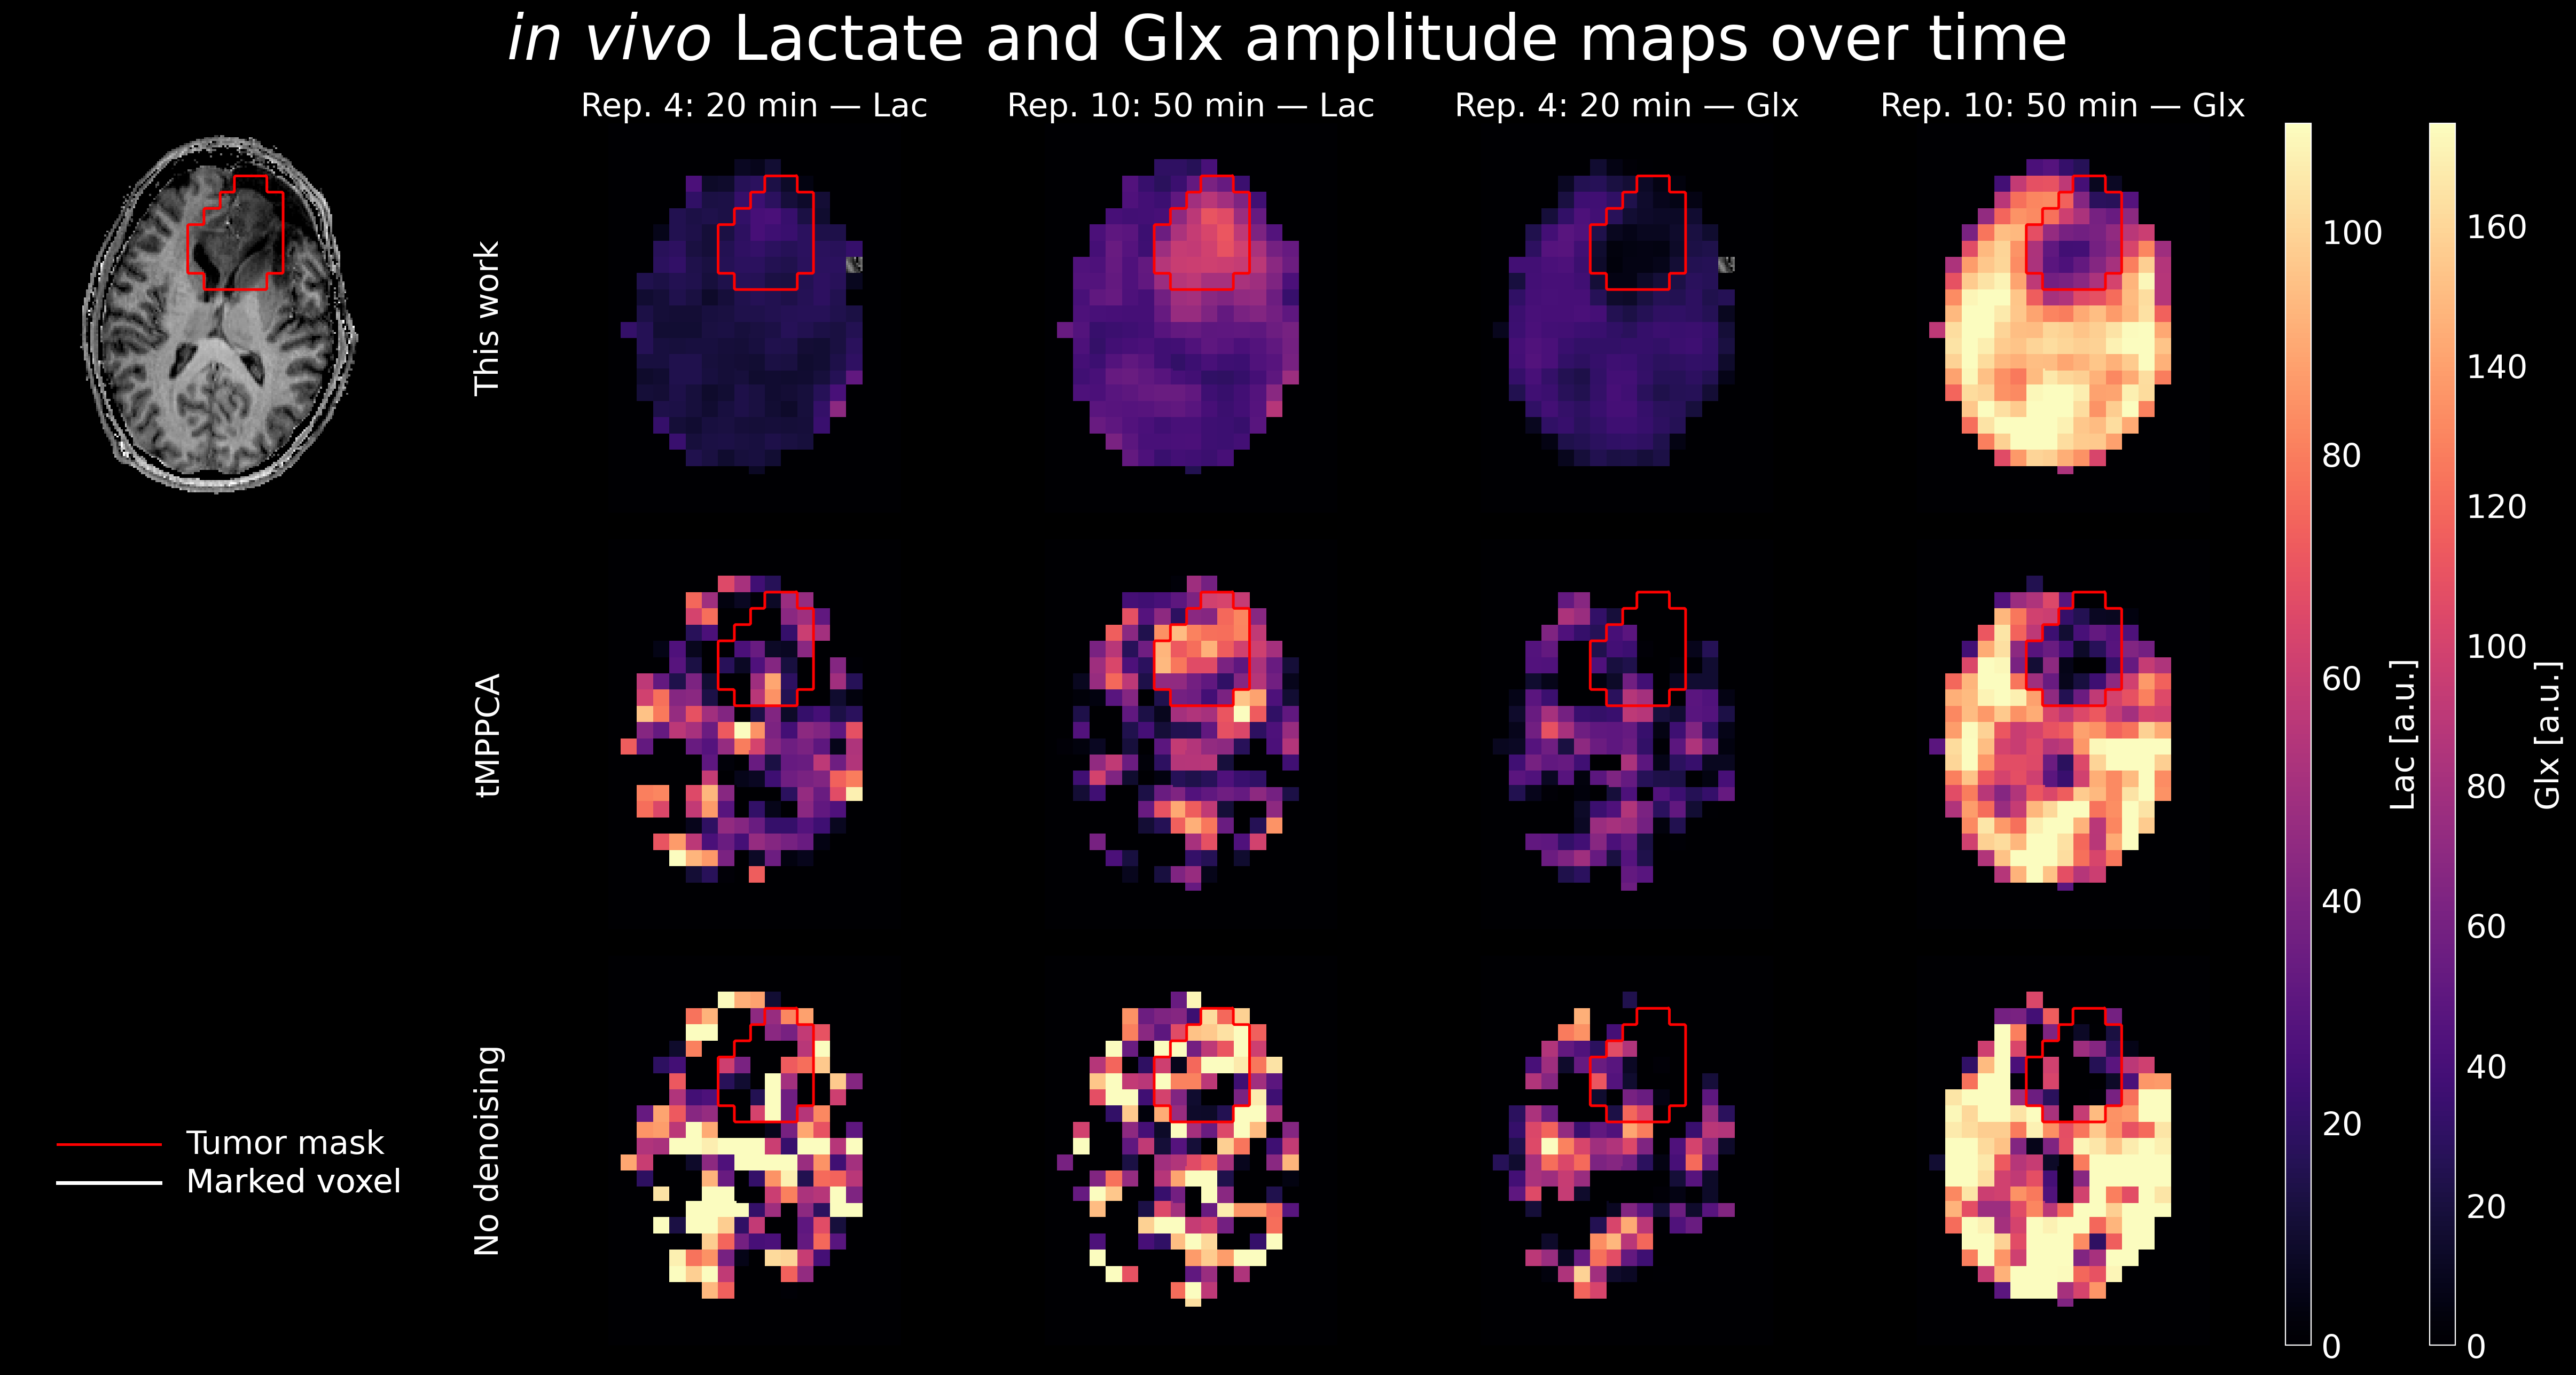

In [13]:
# pip install nibabel matplotlib numpy scikit-image
import os, numpy as np, nibabel as nib
from nibabel.processing import resample_from_to
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

def plot_dmi_timecourse_multi(
    BASE_LIST, T_INDEX_LIST,
    T1_Z=106, DMI_Z=11,
    T1_WINDOW=(1268, 3619),
    LINEWIDTH=1.8, figsize_scale=1.0,
    method_labels=None, rep_labels=None,
    fontsize=22,
    DMI_BOX_I=None, DMI_BOX_J=None, box_linewidth=2.0, box_color='white',
    align_t1_to_dmi=True,
    # feste Skalen optional; sonst Auto über alle Methoden/Zeitpunkte (Perzentile)
    LAC_CLIM=None, GLX_CLIM=None, clim_percentiles=(1, 99)
):
    assert len(BASE_LIST) >= 1
    if method_labels is not None: assert len(method_labels) == len(BASE_LIST)
    if rep_labels is not None:    assert len(rep_labels) == len(T_INDEX_LIST)

    # --- T1 (+ optionale Tumormaske) aus erster Methode ---
    base0 = BASE_LIST[0]
    T1_PATH   = os.path.join(base0, "maps", "magnitude.nii")
    MASK_PATH = os.path.join(base0, "maps", "Tumor_1_mask.nii")  # falls nicht vorhanden, wird ignoriert

    t1_img = nib.load(T1_PATH)
    t1 = t1_img.get_fdata()
    t1_aff, t1_shape = t1_img.affine, t1_img.shape

    mask_t1_nn = None
    if os.path.exists(MASK_PATH):
        mask_img = nib.load(MASK_PATH)
        mask_t1_nn = resample_from_to(mask_img, (t1_shape, t1_aff), order=0).get_fdata() > 0

    # --- DMI-Z -> T1-Z ---
    def dmi_z_to_t1_z(dmi_img, t1_affine, t1_shape, dmi_z):
        sx, sy, _ = dmi_img.shape
        ijk_dmi = np.array([sx/2.0, sy/2.0, dmi_z, 1.0])
        xyz = dmi_img.affine @ ijk_dmi
        ijk_t1 = np.linalg.inv(t1_affine) @ xyz
        return int(np.clip(np.rint(ijk_t1[2]), 0, t1_shape[2]-1))

    # --- Markierungsbox (affine-sicher) ---
    def draw_dmi_voxel_box_via_resample(ax, dmi_img, i, j, dmi_z, t1_shape, t1_affine,
                                        t1_slice_index, edgecolor='white', lw=2.0):
        if i is None or j is None: return
        shp = dmi_img.shape
        if not (0 <= i < shp[0] and 0 <= j < shp[1] and 0 <= dmi_z < shp[2]): return
        mask_dmi = np.zeros(shp, dtype=np.uint8); mask_dmi[i, j, dmi_z] = 1
        mask_t1 = resample_from_to(nib.Nifti1Image(mask_dmi, dmi_img.affine),
                                   (t1_shape, t1_aff), order=0).get_fdata() > 0
        for c in measure.find_contours(mask_t1[..., t1_slice_index].T.astype(float), 0.5):
            ax.plot(c[:,1], c[:,0], color=edgecolor, linewidth=lw)

    # --- Loader für Metabolit (auf T1-Raster) ---
    def load_metab_on_t1(BASE, T_index, metab):  # metab in {"Lac","Glx"}
        p = os.path.join(BASE, "maps", f"{T_index}", "Orig", f"{metab}_amp_map.nii")
        img = nib.load(p)
        return resample_from_to(img, (t1_shape, t1_aff), order=0).get_fdata()

    # globale DMI→T1-Slice
    lac0_img_for_z = nib.load(os.path.join(BASE_LIST[0], "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
    T1_Z_MATCH_GLOBAL = dmi_z_to_t1_z(lac0_img_for_z, t1_aff, t1_shape, DMI_Z)

    # --- Auto-CLIMs, falls nicht vorgegeben: über ALLE Methoden & Zeitpunkte ---
    def gather_vals(metab):
        vals = []
        for B in BASE_LIST:
            for T in T_INDEX_LIST:
                a = load_metab_on_t1(B, T, metab)
                vals.append(a[np.isfinite(a)])
        vals = np.concatenate(vals) if len(vals)>1 else vals[0]
        p1, p99 = np.percentile(vals, clim_percentiles)
        if p1 == p99: p99 = p1 + 1.0
        return (float(p1), float(p99))

    if LAC_CLIM is None: LAC_CLIM = gather_vals("Lac")
    if GLX_CLIM is None: GLX_CLIM = gather_vals("Glx")

    # === Layout: T1 | Label | (alle Lac) | (alle Glx) | Cbar Lac | Cbar Glx ===
    n_times = len(T_INDEX_LIST)
    nrows = len(BASE_LIST)
    ncols = 1 + 1 + n_times + n_times + 2

    fig_w = figsize_scale * (ncols * 3.0)
    fig_h = figsize_scale * (nrows * 4.0)
    fig = plt.figure(figsize=(fig_w, fig_h), dpi=200, constrained_layout=True)
    fig.patch.set_facecolor('black')

    width_ratios = [1, 0.2] + [1]*n_times + [1]*n_times + [0.06, 0.06]
    gs = GridSpec(nrows, ncols, figure=fig, width_ratios=width_ratios, height_ratios=[1]*nrows)

    cmap_t1  = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
    cmap_lac = mpl.cm.get_cmap("magma")
    cmap_glx = mpl.cm.get_cmap("magma")
    norm_lac = mpl.colors.Normalize(vmin=LAC_CLIM[0], vmax=LAC_CLIM[1], clip=True)
    norm_glx = mpl.colors.Normalize(vmin=GLX_CLIM[0], vmax=GLX_CLIM[1], clip=True)
    t1_vmin, t1_vmax = T1_WINDOW

    last_im_lac = None
    last_im_glx = None

    for r, BASE in enumerate(BASE_LIST):
        # Slice-Matching für diese Zeile
        lac0_img = nib.load(os.path.join(BASE, "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
        T1_Z_MATCH = dmi_z_to_t1_z(lac0_img, t1_aff, t1_shape, DMI_Z)

        # T1 (nur erste Zeile)
        if r == 0:
            ax_t1 = fig.add_subplot(gs[r, 0]); ax_t1.axis('off')
            zshow = T1_Z_MATCH_GLOBAL if align_t1_to_dmi else T1_Z
            ax_t1.imshow(t1[..., zshow].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                         origin='lower', interpolation='nearest')
            if mask_t1_nn is not None:
                for c in measure.find_contours(mask_t1_nn[..., zshow].T.astype(float), 0.5):
                    ax_t1.plot(c[:,1], c[:,0], color='red', linewidth=LINEWIDTH)
            if DMI_BOX_I is not None and DMI_BOX_J is not None:
                draw_dmi_voxel_box_via_resample(ax_t1, lac0_img_for_z, DMI_BOX_I, DMI_BOX_J, DMI_Z,
                                                t1_shape, t1_aff, zshow, edgecolor=box_color, lw=box_linewidth)
        else:
            ax_blank = fig.add_subplot(gs[r, 0]); ax_blank.axis('off'); ax_blank.set_facecolor('black')

        # vertikales Methodenlabel
        ax_label = fig.add_subplot(gs[r, 1]); ax_label.axis('off'); ax_label.set_facecolor('black')
        label = method_labels[r] if method_labels is not None else os.path.basename(os.path.normpath(BASE))
        ax_label.text(0.5, 0.5, label, color='white', fontsize=fontsize,
                      rotation=90, ha='center', va='center', transform=ax_label.transAxes)

        # --- LAC-Blöcke (alle Zeiten nebeneinander) ---
        for j, T in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, 2 + j]); ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            lac = load_metab_on_t1(BASE, T, "Lac")
            last_im_lac = ax.imshow(np.ma.masked_invalid(lac[..., T1_Z_MATCH].T),
                                    cmap=cmap_lac, norm=norm_lac, origin='lower', interpolation='nearest')
            if mask_t1_nn is not None:
                for c in measure.find_contours(mask_t1_nn[..., T1_Z_MATCH].T.astype(float), 0.5):
                    ax.plot(c[:,1], c[:,0], color='red', linewidth=LINEWIDTH)
            if r == 0:
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"{tlabel} — Lac", color='white', fontsize=fontsize, pad=4)

        # --- GLX-Blöcke (alle Zeiten nebeneinander) ---
        glx_offset = 2 + n_times  # Startspalte der Glx-Blöcke
        for j, T in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, glx_offset + j]); ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            glx = load_metab_on_t1(BASE, T, "Glx")
            last_im_glx = ax.imshow(np.ma.masked_invalid(glx[..., T1_Z_MATCH].T),
                                    cmap=cmap_glx, norm=norm_glx, origin='lower', interpolation='nearest')
            if mask_t1_nn is not None:
                for c in measure.find_contours(mask_t1_nn[..., T1_Z_MATCH].T.astype(float), 0.5):
                    ax.plot(c[:,1], c[:,0], color='red', linewidth=LINEWIDTH)
            if r == 0:
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"{tlabel} — Glx", color='white', fontsize=fontsize, pad=4)

    # --- zwei globale Colorbars ---
    cax_lac = fig.add_subplot(gs[:, ncols-2])
    if last_im_lac is not None:
        cbar_lac = fig.colorbar(last_im_lac, cax=cax_lac)
        cbar_lac.ax.set_facecolor('black'); cbar_lac.outline.set_edgecolor('white')
        plt.setp(cbar_lac.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar_lac.set_label("Lac [a.u.]", color='white', fontsize=fontsize)

    cax_glx = fig.add_subplot(gs[:, ncols-1])
    if last_im_glx is not None:
        cbar_glx = fig.colorbar(last_im_glx, cax=cax_glx)
        cbar_glx.ax.set_facecolor('black'); cbar_glx.outline.set_edgecolor('white')
        plt.setp(cbar_glx.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar_glx.set_label("Glx [a.u.]", color='white', fontsize=fontsize)

    fig.suptitle("$\\it{in\\ vivo}$ Lactate and Glx amplitude maps over time ",
             color='white', fontsize=fontsize + 20, y=1.06)

    # Legende: Marked voxel
    legend_x, legend_y, legend_dx = 0.02, 0.175, 0.04
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                              [legend_y - 0.03, legend_y - 0.03],
                              color='white', linewidth=box_linewidth,
                              transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y - 0.03, "Marked voxel",
             color='white', va='center', fontsize=fontsize, transform=fig.transFigure)

    # --- Legende unten links ---
    legend_x = 0.02   # horizontaler Abstand vom linken Rand
    legend_y = 0.175  # vertikaler Abstand vom unteren Rand
    legend_dx = 0.04  # Länge der Linien

    # Tumor mask (rot)
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                              [legend_y, legend_y],
                              color='red', linewidth=LINEWIDTH,
                              transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y, "Tumor mask",
             color='white', va='center', fontsize=fontsize, transform=fig.transFigure)

    # Marked voxel (weiß)
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                              [legend_y - 0.03, legend_y - 0.03],
                              color='white', linewidth=box_linewidth,
                              transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y - 0.03, "Marked voxel",
             color='white', va='center', fontsize=fontsize, transform=fig.transFigure)


    plt.show()
    fig.savefig("output.pdf", bbox_inches='tight', facecolor=fig.get_facecolor())


# Beispielaufruf (unverändert):
plot_dmi_timecourse_multi(
    BASE_LIST=[
        "MetabMaps/Tumor_1_deep_tMPPCA_5D",
        "MetabMaps/Tumor_1_tMPPCA_5D",
        "MetabMaps/Tumor_1_noisy"
    ],
    T_INDEX_LIST=[4,10],
    method_labels=["This work", "tMPPCA", "No denoising"],
    rep_labels=["Rep. 4: 20 min", "Rep. 10: 50 min"],
    DMI_BOX_I=None, DMI_BOX_J=None, DMI_Z=11,
    align_t1_to_dmi=True,
    box_linewidth=2.5, box_color='white'
    # Optional feste Skalen:
    # LAC_CLIM=(0,2.0), GLX_CLIM=(0,2.0)
)

/tmp/ipykernel_2096892/774872031.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_t1  = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
/tmp/ipykernel_2096892/774872031.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lac = mpl.cm.get_cmap("magma")
/tmp/ipykernel_2096892/774872031.py:131: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_glx = mpl.cm.get_cmap("magma")


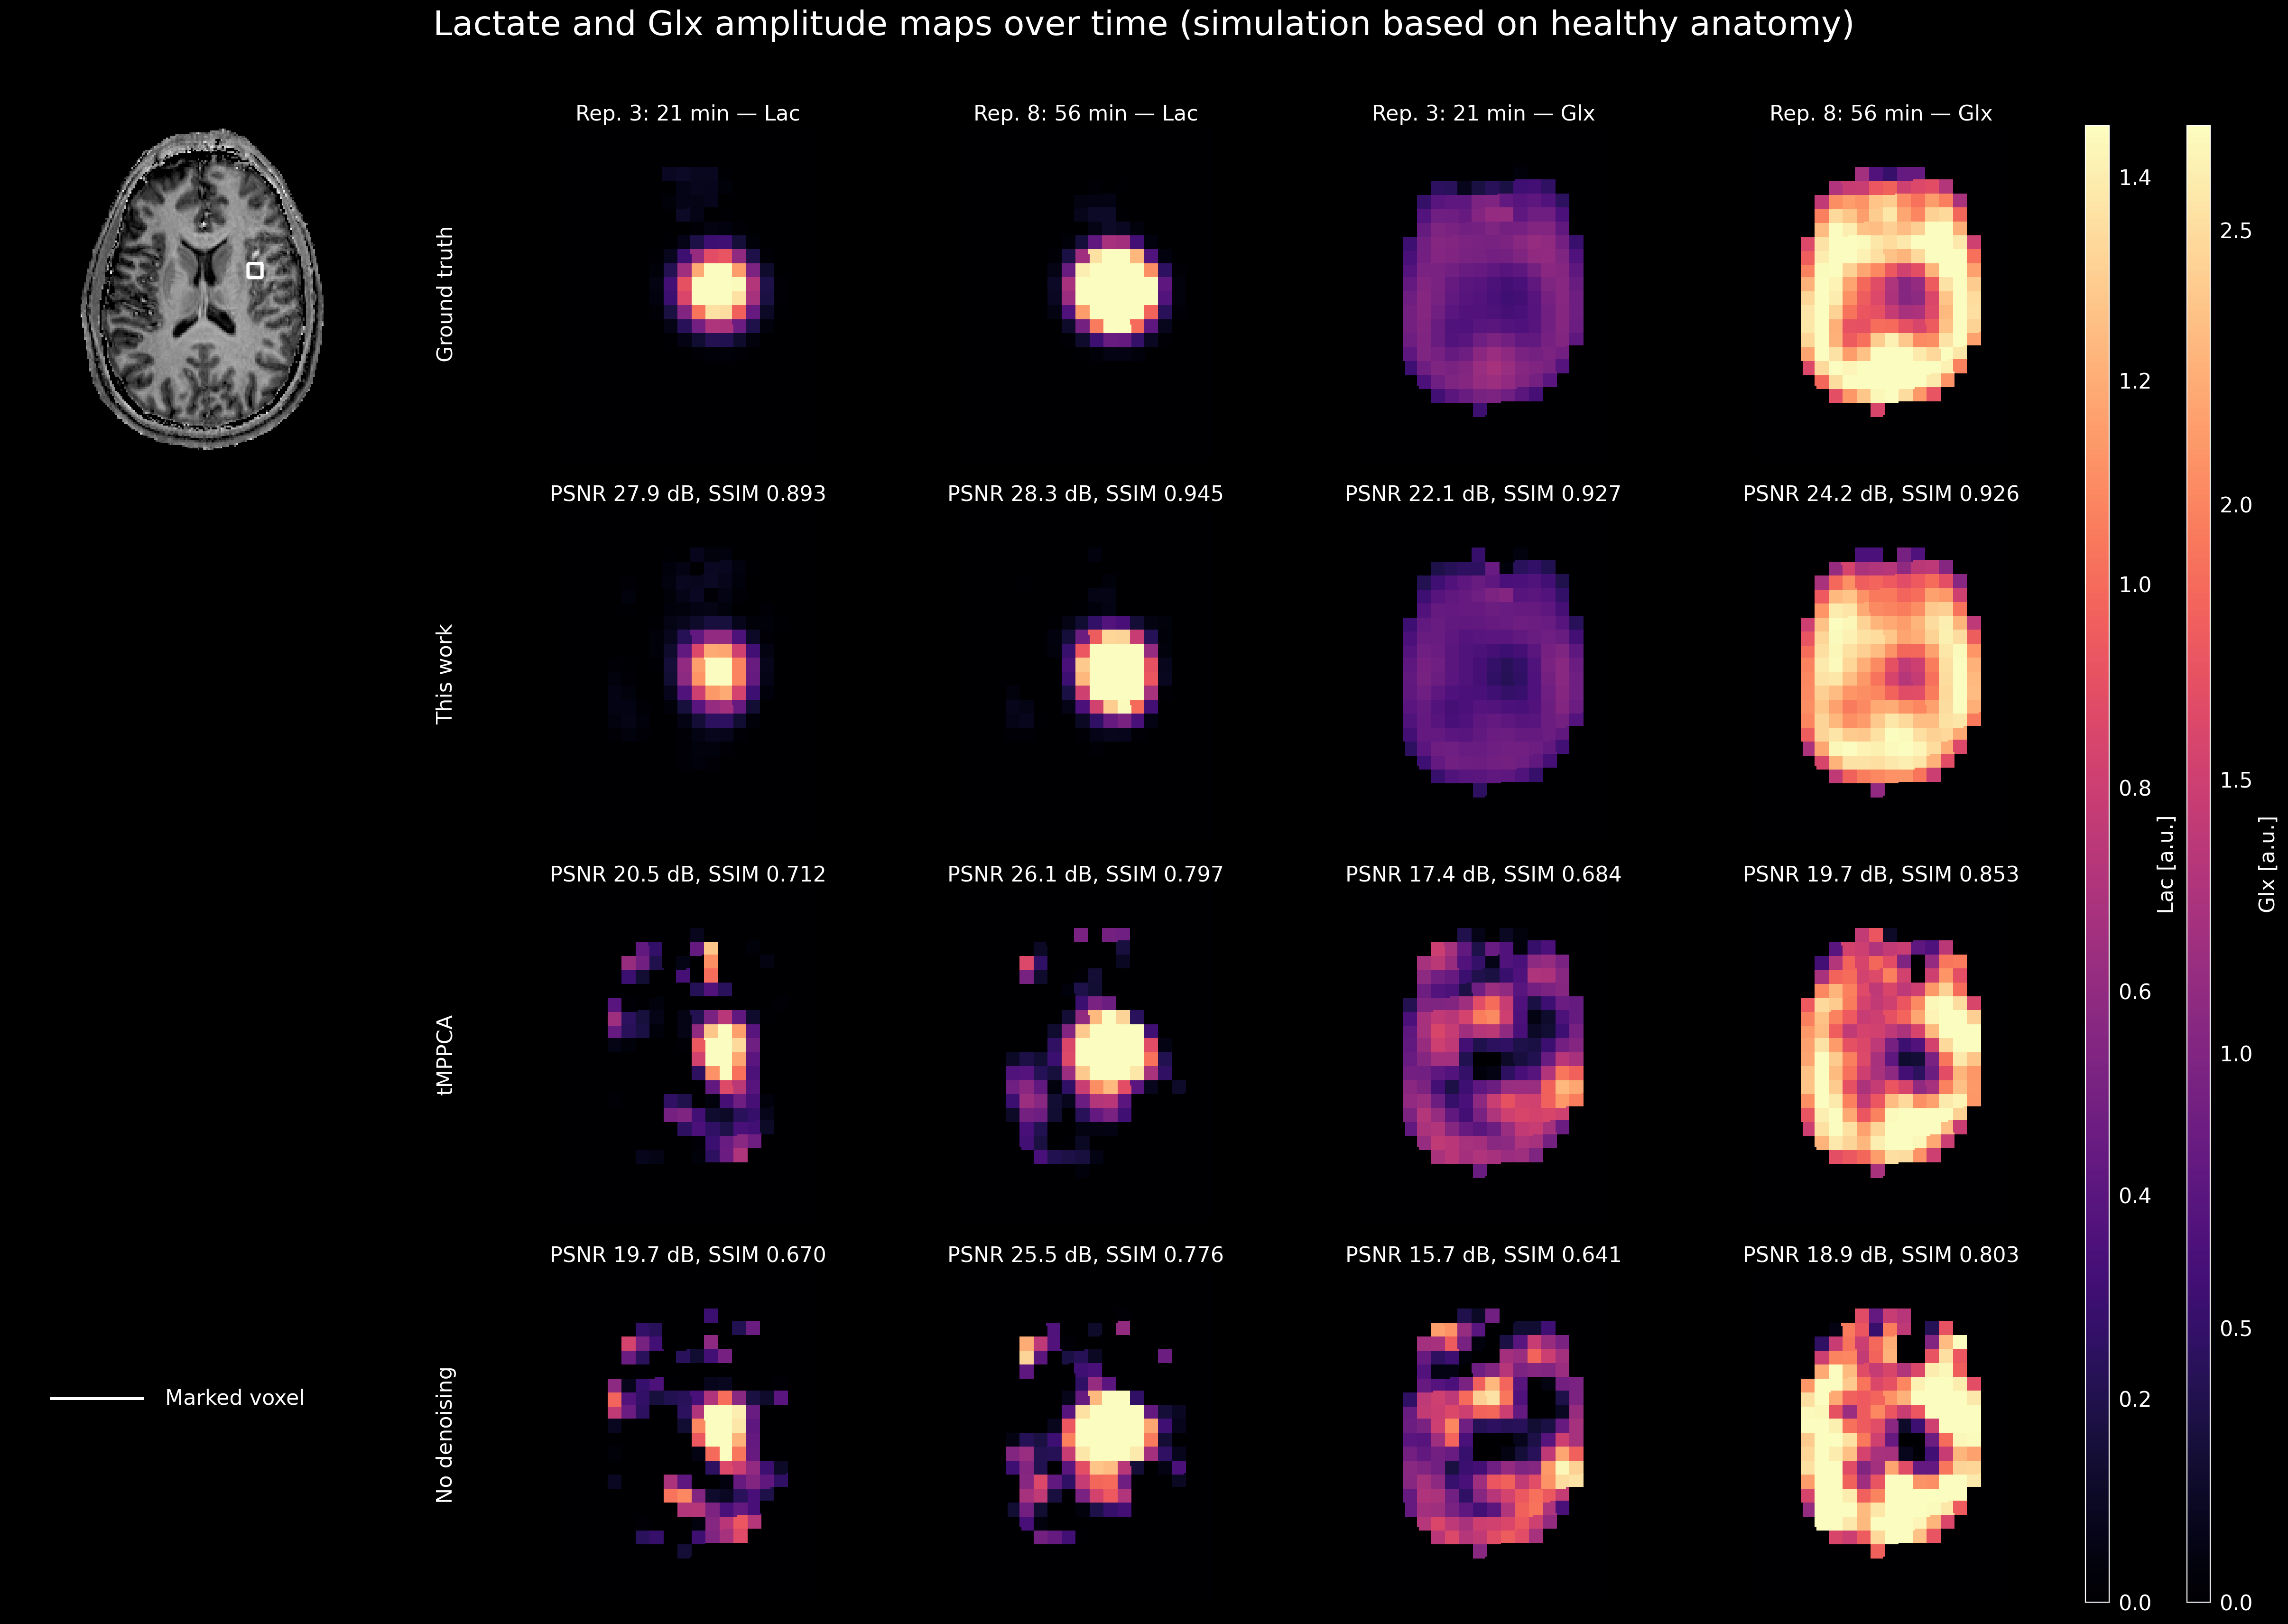

In [14]:
# pip install nibabel matplotlib numpy scikit-image
import os, numpy as np, nibabel as nib
from nibabel.processing import resample_from_to
from skimage import measure
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

def plot_dmi_timecourse_simulation(
    BASE_LIST, T_INDEX_LIST,
    T1_Z=106, DMI_Z=11,
    T1_WINDOW=(1268, 3619),
    LINEWIDTH=1.8, figsize_scale=1.0,
    method_labels=None, rep_labels=None,
    fontsize=16,
    DMI_BOX_I=None, DMI_BOX_J=None, box_linewidth=2.0, box_color='white',
    align_t1_to_dmi=True,
    LAC_CLIM=None, GLX_CLIM=None, clim_percentiles=(1, 99),
    # Neu:
    BRAIN_MASK_PATH=None,                 # optional: Metriken nur innerhalb Maske
    show_metrics=True, metrics_box=False  # metrics_box=False: Metriken nur im Titel
):
    """
    Simulation:
    - Keine Tumormaske/Legende.
    - Titel: '... (simulation based on healthy anatomy)'
    - PSNR/SSIM vs. Ground Truth (erste Methode) in den Map-Titeln der anderen Methoden.
    """
    assert len(BASE_LIST) >= 1
    if method_labels is not None: assert len(method_labels) == len(BASE_LIST)
    if rep_labels is not None:    assert len(rep_labels) == len(T_INDEX_LIST)

    # --- T1 laden ---
    base0 = BASE_LIST[0]
    T1_PATH = os.path.join(base0, "maps", "magnitude.nii")
    t1_img = nib.load(T1_PATH)
    t1 = t1_img.get_fdata()
    t1_aff, t1_shape = t1_img.affine, t1_img.shape

    # optional: Hirnmaske
    brain_mask_t1 = None
    if BRAIN_MASK_PATH is not None and os.path.exists(BRAIN_MASK_PATH):
        brain_mask_t1 = resample_from_to(nib.load(BRAIN_MASK_PATH), (t1_shape, t1_aff), order=0).get_fdata() > 0

    # --- DMI-Z -> T1-Z ---
    def dmi_z_to_t1_z(dmi_img, t1_affine, t1_shape, dmi_z):
        sx, sy, _ = dmi_img.shape
        ijk_dmi = np.array([sx/2.0, sy/2.0, dmi_z, 1.0])
        xyz = dmi_img.affine @ ijk_dmi
        ijk_t1 = np.linalg.inv(t1_affine) @ xyz
        return int(np.clip(np.rint(ijk_t1[2]), 0, t1_shape[2]-1))

    # --- Markierungsbox (affine-sicher) ---
    def draw_dmi_voxel_box_via_resample(ax, dmi_img, i, j, dmi_z, t1_shape, t1_affine,
                                        t1_slice_index, edgecolor='white', lw=2.0):
        if i is None or j is None: return
        shp = dmi_img.shape
        if not (0 <= i < shp[0] and 0 <= j < shp[1] and 0 <= dmi_z < shp[2]): return
        mask_dmi = np.zeros(shp, dtype=np.uint8); mask_dmi[i, j, dmi_z] = 1
        mask_t1 = resample_from_to(nib.Nifti1Image(mask_dmi, dmi_img.affine),
                                   (t1_shape, t1_aff), order=0).get_fdata() > 0
        for c in measure.find_contours(mask_t1[..., t1_slice_index].T.astype(float), 0.5):
            ax.plot(c[:,1], c[:,0], color=edgecolor, linewidth=lw)

    # --- Loader für Metabolit (auf T1-Raster) ---
    def load_metab_on_t1(BASE, T_index, metab):
        p = os.path.join(BASE, "maps", f"{T_index}", "Orig", f"{metab}_amp_map.nii")
        img = nib.load(p)
        return resample_from_to(img, (t1_shape, t1_aff), order=0).get_fdata()

    # --- Metriken (2D) innerhalb Maske (Slice) ---
    def compute_metrics_2d(gt2d, im2d, mask2d):
        valid = np.isfinite(gt2d) & np.isfinite(im2d)
        if mask2d is not None:
            valid &= mask2d.astype(bool)
        if not np.any(valid):
            return np.nan, np.nan
        gt = gt2d[valid].astype(np.float32)
        im = im2d[valid].astype(np.float32)
        data_range = float(max(gt.max(), im.max()) - min(gt.min(), im.min()))
        if data_range == 0:
            return np.inf, 1.0
        psnr = peak_signal_noise_ratio(gt, im, data_range=data_range)
        # Für SSIM ein gefülltes 2D-Bild verwenden:
        im2d_f = im2d.copy(); gt2d_f = gt2d.copy()
        # NaNs draußen auffüllen (mit GT), damit SSIM stabil ist
        im2d_f[~np.isfinite(im2d_f)] = gt2d_f[~np.isfinite(im2d_f)]
        if mask2d is not None:
            outside = ~mask2d.astype(bool)
            im2d_f[outside] = gt2d_f[outside]
        ssim = structural_similarity(gt2d_f.astype(np.float32),
                                     im2d_f.astype(np.float32),
                                     data_range=data_range)
        return psnr, ssim

    # globale DMI→T1-Slice
    lac0_img_for_z = nib.load(os.path.join(BASE_LIST[0], "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
    T1_Z_MATCH_GLOBAL = dmi_z_to_t1_z(lac0_img_for_z, t1_aff, t1_shape, DMI_Z)

    # --- Auto-CLIMs ---
    def gather_vals(metab):
        vals = []
        for B in BASE_LIST:
            for T in T_INDEX_LIST:
                a = load_metab_on_t1(B, T, metab)
                vals.append(a[np.isfinite(a)])
        vals = np.concatenate(vals)
        p1, p99 = np.percentile(vals, clim_percentiles)
        if p1 == p99: p99 = p1 + 1.0
        return (float(p1), float(p99))

    if LAC_CLIM is None: LAC_CLIM = gather_vals("Lac")
    if GLX_CLIM is None: GLX_CLIM = gather_vals("Glx")

    # === Layout: T1 | Label | alle Lac | alle Glx | Cbar Lac | Cbar Glx ===
    n_times = len(T_INDEX_LIST)
    nrows = len(BASE_LIST)
    ncols = 1 + 1 + n_times + n_times + 2

    fig_w = figsize_scale * (ncols * 3.0)
    fig_h = figsize_scale * (nrows * 4.0)
    fig = plt.figure(figsize=(fig_w, fig_h), dpi=200, constrained_layout=True)
    fig.patch.set_facecolor('black')

    width_ratios = [1, 0.2] + [1]*n_times + [1]*n_times + [0.06, 0.06]
    gs = GridSpec(nrows, ncols, figure=fig, width_ratios=width_ratios, height_ratios=[1]*nrows)

    cmap_t1  = mpl.cm.get_cmap("gray").copy(); cmap_t1.set_under("black")
    cmap_lac = mpl.cm.get_cmap("magma")
    cmap_glx = mpl.cm.get_cmap("magma")
    norm_lac = mpl.colors.Normalize(vmin=LAC_CLIM[0], vmax=LAC_CLIM[1], clip=True)
    norm_glx = mpl.colors.Normalize(vmin=GLX_CLIM[0], vmax=GLX_CLIM[1], clip=True)
    t1_vmin, t1_vmax = T1_WINDOW

    last_im_lac = None
    last_im_glx = None

    # --- Ground Truth Maps preload (erste Methode) ---
    GT_BASE = BASE_LIST[0]
    gt_lac = {T: load_metab_on_t1(GT_BASE, T, "Lac") for T in T_INDEX_LIST}
    gt_glx = {T: load_metab_on_t1(GT_BASE, T, "Glx") for T in T_INDEX_LIST}

    for r, BASE in enumerate(BASE_LIST):
        lac0_img = nib.load(os.path.join(BASE, "maps", f"{T_INDEX_LIST[0]}", "Orig", "Lac_amp_map.nii"))
        T1_Z_MATCH = dmi_z_to_t1_z(lac0_img, t1_aff, t1_shape, DMI_Z)

        # T1 (nur erste Zeile)
        if r == 0:
            ax_t1 = fig.add_subplot(gs[r, 0]); ax_t1.axis('off')
            zshow = T1_Z_MATCH_GLOBAL if align_t1_to_dmi else T1_Z
            ax_t1.imshow(t1[..., zshow].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                         origin='lower', interpolation='nearest')
            if DMI_BOX_I is not None and DMI_BOX_J is not None:
                draw_dmi_voxel_box_via_resample(ax_t1, lac0_img_for_z, DMI_BOX_I, DMI_BOX_J, DMI_Z,
                                                t1_shape, t1_aff, zshow, edgecolor=box_color, lw=box_linewidth)
        else:
            ax_blank = fig.add_subplot(gs[r, 0]); ax_blank.axis('off'); ax_blank.set_facecolor('black')

        # Methodenlabel
        ax_label = fig.add_subplot(gs[r, 1]); ax_label.axis('off'); ax_label.set_facecolor('black')
        label = method_labels[r] if method_labels is not None else os.path.basename(os.path.normpath(BASE))
        ax_label.text(0.5, 0.5, label, color='white', fontsize=fontsize,
                      rotation=90, ha='center', va='center', transform=ax_label.transAxes)

        # --- LAC-Blöcke (alle Zeiten) ---
        for j, T in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, 2 + j]); ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            lac = load_metab_on_t1(BASE, T, "Lac")
            last_im_lac = ax.imshow(np.ma.masked_invalid(lac[..., T1_Z_MATCH].T),
                                    cmap=cmap_lac, norm=norm_lac, origin='lower', interpolation='nearest')

            # Titel mit Metriken (nicht für GT-Zeile)
            if r == 0:
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"{tlabel} — Lac", color='white', fontsize=fontsize, pad=4)
            elif show_metrics:
                psnr, ssim = compute_metrics_2d(gt_lac[T][..., T1_Z_MATCH], lac[..., T1_Z_MATCH],
                                                brain_mask_t1[..., T1_Z_MATCH] if brain_mask_t1 is not None else None)
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"PSNR {psnr:0.1f} dB, SSIM {ssim:0.3f}",
                             color='white', fontsize=fontsize, pad=4)

        # --- GLX-Blöcke (alle Zeiten) ---
        glx_offset = 2 + n_times
        for j, T in enumerate(T_INDEX_LIST):
            ax = fig.add_subplot(gs[r, glx_offset + j]); ax.axis('off')
            ax.imshow(t1[..., T1_Z_MATCH].T, cmap=cmap_t1, vmin=t1_vmin, vmax=t1_vmax,
                      origin='lower', interpolation='nearest')
            glx = load_metab_on_t1(BASE, T, "Glx")
            last_im_glx = ax.imshow(np.ma.masked_invalid(glx[..., T1_Z_MATCH].T),
                                    cmap=cmap_glx, norm=norm_glx, origin='lower', interpolation='nearest')

            if r == 0:
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"{tlabel} — Glx", color='white', fontsize=fontsize, pad=4)
            elif show_metrics:
                psnr, ssim = compute_metrics_2d(gt_glx[T][..., T1_Z_MATCH], glx[..., T1_Z_MATCH],
                                                brain_mask_t1[..., T1_Z_MATCH] if brain_mask_t1 is not None else None)
                tlabel = rep_labels[j] if rep_labels is not None else f"T={T}"
                ax.set_title(f"PSNR {psnr:0.1f} dB, SSIM {ssim:0.3f}",
                             color='white', fontsize=fontsize, pad=4)

    # --- Colorbars ---
    cax_lac = fig.add_subplot(gs[:, ncols-2])
    if last_im_lac is not None:
        cbar_lac = fig.colorbar(last_im_lac, cax=cax_lac)
        cbar_lac.ax.set_facecolor('black'); cbar_lac.outline.set_edgecolor('white')
        plt.setp(cbar_lac.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar_lac.set_label("Lac [a.u.]", color='white', fontsize=fontsize)

    cax_glx = fig.add_subplot(gs[:, ncols-1])
    if last_im_glx is not None:
        cbar_glx = fig.colorbar(last_im_glx, cax=cax_glx)
        cbar_glx.ax.set_facecolor('black'); cbar_glx.outline.set_edgecolor('white')
        plt.setp(cbar_glx.ax.get_yticklabels(), color='white', fontsize=fontsize)
        cbar_glx.set_label("Glx [a.u.]", color='white', fontsize=fontsize)

    # Titel
    fig.suptitle(
        "Lactate and Glx amplitude maps over time (simulation based on healthy anatomy)",
        color='white', fontsize=fontsize + 10, y=1.06
    )

    # Nur Marked voxel Legende
    legend_x, legend_y, legend_dx = 0.02, 0.175, 0.04
    fig.add_artist(plt.Line2D([legend_x, legend_x + legend_dx],
                              [legend_y - 0.03, legend_y - 0.03],
                              color='white', linewidth=box_linewidth,
                              transform=fig.transFigure, figure=fig))
    fig.text(legend_x + legend_dx + 0.01, legend_y - 0.03, "Marked voxel",
             color='white', va='center', fontsize=fontsize, transform=fig.transFigure)

    plt.show()
    fig.savefig("output_simulation.pdf", bbox_inches='tight', facecolor=fig.get_facecolor())

# Beispielaufruf (unverändert):
plot_dmi_timecourse_simulation(
    BASE_LIST=[
        "MetabMaps/Lesion_Double_GT",
        "MetabMaps/Lesion_Double_deep_tMPPCA_5D",
        "MetabMaps/Lesion_Double_tMPPCA_5D",
        "MetabMaps/Lesion_Double_Noisy"
    ],
    T_INDEX_LIST=[3,8],
    method_labels=["Ground truth", "This work", "tMPPCA", "No denoising"],
    rep_labels=["Rep. 3: 21 min", "Rep. 8: 56 min"],
    DMI_BOX_I=14, DMI_BOX_J=12, DMI_Z=11,
    align_t1_to_dmi=True,
    box_linewidth=2.5, box_color='white'
    # Optional feste Skalen:
    # LAC_CLIM=(0,2.0), GLX_CLIM=(0,2.0)
)